<a href="https://colab.research.google.com/github/tarachari3/perturbCME/blob/main/notebooks/gg211116_crisprfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov chains for length bias quantification in scRNA-seq: a Colab demonstration

In this notebook, we illustrate a Markov chain approach for joint probabilistic description of technical and biological noise in scRNA-seq.

We implement a [conventional two-stage model](https://www.sciencedirect.com/science/article/pii/S0006349512007904?via%3Dihub) for the living cell dynamics. Unspliced mRNA transcripts are produced in geometric bursts. These unspliced transcripts are spliced, then degraded. After equilibration, the sequencing process starts, halting all biological processes. The cDNA library construction is a pure-birth process: it yields $Poisson(\lambda_u)$ *in silico* UMIs for each unspliced mRNA and $Poisson(\lambda_s)$ UMIs for each spliced mRNA.

We use a length-dependent model of UMI capture. Specifically, we posit that $\lambda_u = C_u L$, where $L$ is the length of the full gene: longer genes have more poly(A) stretches that can be captured by the oligo(dT) primers used in scRNA-seq. On the other hand, $\lambda_s$ is presumed constant across all genes: spliced transcripts are primarily captured at the poly(A) tail appended before nuclear export.

We scan over a grid of $\{C_u, \lambda_s\}$ values, compute the conditional maximum likelihood estimates for the biological parameters, identify a sampling parameter optimum, and investigate parameter trends and fit quality. 

In [1]:
from datetime import date
import time
t1 = time.time()

## Prerequisites

First, install the necessary numerical differentiation, parallelization, and `loom` file import packages.

In [ ]:
# !pip -q install numdifftools 
# !pip -q install parfor
# !pip -q install loompy

     |████████████████████████████████| 99 kB 4.3 MB/s 
     |████████████████████████████████| 189 kB 38.7 MB/s 
     |████████████████████████████████| 41 kB 123 kB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

Clone the project GitHub repository to collect the data and processing scripts. The [10X](https://figshare.com/articles/dataset/10X_protein_and_mRNA_counts/9912734/1?file=17820449) dataset was processed using `kb` for the [protein velocity article](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1945-3), collected from Figshare, and uploaded to Github.

In [4]:
!git clone https://github.com/gennadygorin/seq-cme-technoise

Cloning into 'seq-cme-technoise'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 359 (delta 96), reused 115 (delta 58), pack-reused 199
Receiving objects: 100% (359/359), 53.57 MiB | 22.45 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [5]:
!mv seq-cme-technoise/* .
#!rm -r seq-cme-technoise

In [6]:
!mv polyA_ref/* .

## Inference

Import the processing scripts.

In [4]:
from seq_cme_inference import *
from driver import *

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

The driver inputs a text file with parameters. The most salient ones are:


* `loom_filenames`: which `loom` files to fit? If multiple dataset names are listed, the process collects genes that are retained after filtering in *all* datasets. The specific file to analyze is indicated by the zero-indexed entry `IND`.
* `phys_lb` and `phys_ub`: what are the lower and upper bounds on $\log_{10}$ of the physical parameters $b$, $\beta$, and $\gamma$ = burst size, splicing rate, and degradation rate? Note that the rates are normalized to burst frequency $k_i$.
* `samp_lb` and `samp_ub`: what are the lower and upper bounds on $\log_{10}$ of the sampling parameters $C_u$ and $\lambda_s$? These parameters are scanned on a grid of dimensions `n_pt1`$\times$`n_pt2`.


In [45]:
#Make script in future to make these automatically (from user input)
#For dry-run set test loom file index to -1, selected genes then filtered, up to 100 genes
!cat ../example_input_hagC1.txt 

#Parameter input for CME inference 
dataset_directory : /home/tchari/counts/hagai_lps/24754_6/counts_filtered/ : folder with dataset loom files
result_directory : /home/tchari/counts/hagai_lps/loom_res/ : where to put the result folder
loom_filenames : adata_24754_6 : filenames to integrate
transcriptome_filename : gg_200524_mouse_genome_polyA_cum_1 : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 500, 500, 1, 1, -1 : first six: min threshold for mean, max threshold for max, min threshold for max; odd is U, even is S. final: if -1, ignore clusters in filtering
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','gene_name','barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 123 : gene selection seed
n_gen : 5000 : number of genes to select
IND :

Run the inference workflow. This will input the `loom` file, select genes with moderate expression (dark gray in second figure), and select a subset of those to fit (blue in second figure).

Each run creates a directory with the date and metadata (dataset name, grid size, number of genes). Some metadata can be defined in the input text file. The grid scan runs in parallel. The procedure is stable for searches with a lot of genes and grid points: if the algorithm halts, the intermediate results are stored.

The directory contains files for each grid point, a `metadata` file that defines the search parameters, a `nosamp` file with results for the noise-free fit, and a `result` file that bundles all results together and can be imported for further analysis.

In [ ]:
#May need to curb OpenBlas threads
#!export OMP_NUM_THREADS=1

['/home/tchari/counts/hagai_lps/24754_6/counts_filtered/adata_24754_6.loom']
Beginning preprocessing routine:
Dataset: /home/tchari/counts/hagai_lps/24754_6/counts_filtered/adata_24754_6.loom
32285 features observed, 32005 match genome annotations. 31649 are unique. 
3745 cells detected.
31649 genes retained as high-expression.
5580 genes retained in loom structure based on filter.
Gene set size: 5580
-----------
5000 genes selected.
Gene set selected!
Beginning search routine.
32285 features observed, 32005 match genome annotations. 31649 are unique. 
3745 cells detected.
Directory /home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_24754_6_10x11_5000gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 17.8 min.


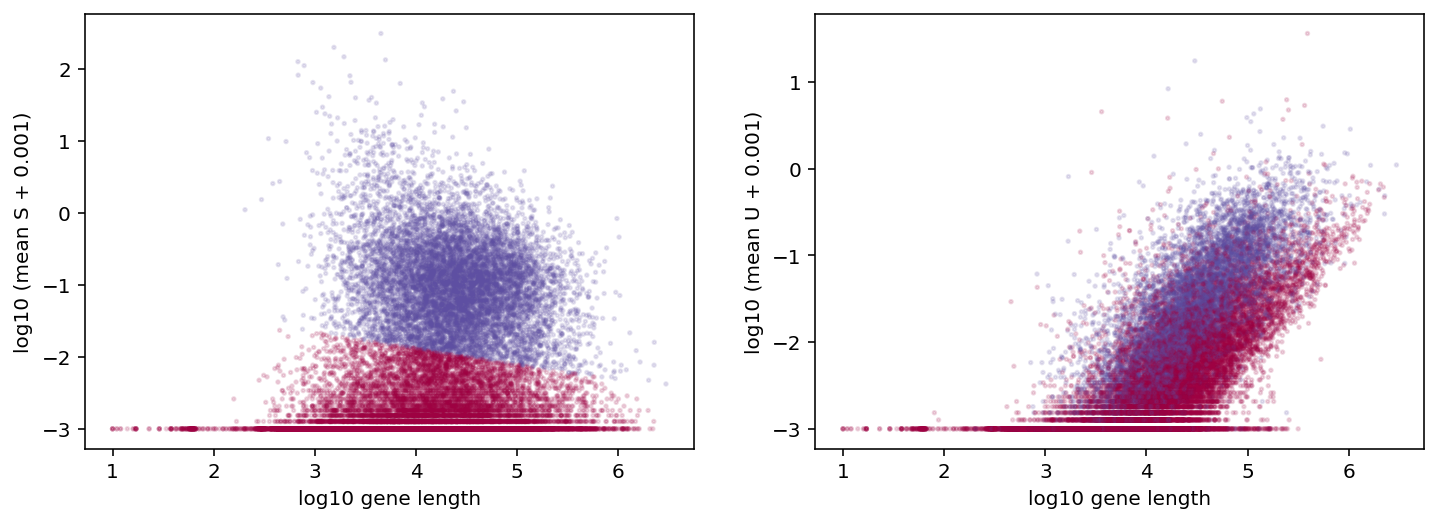

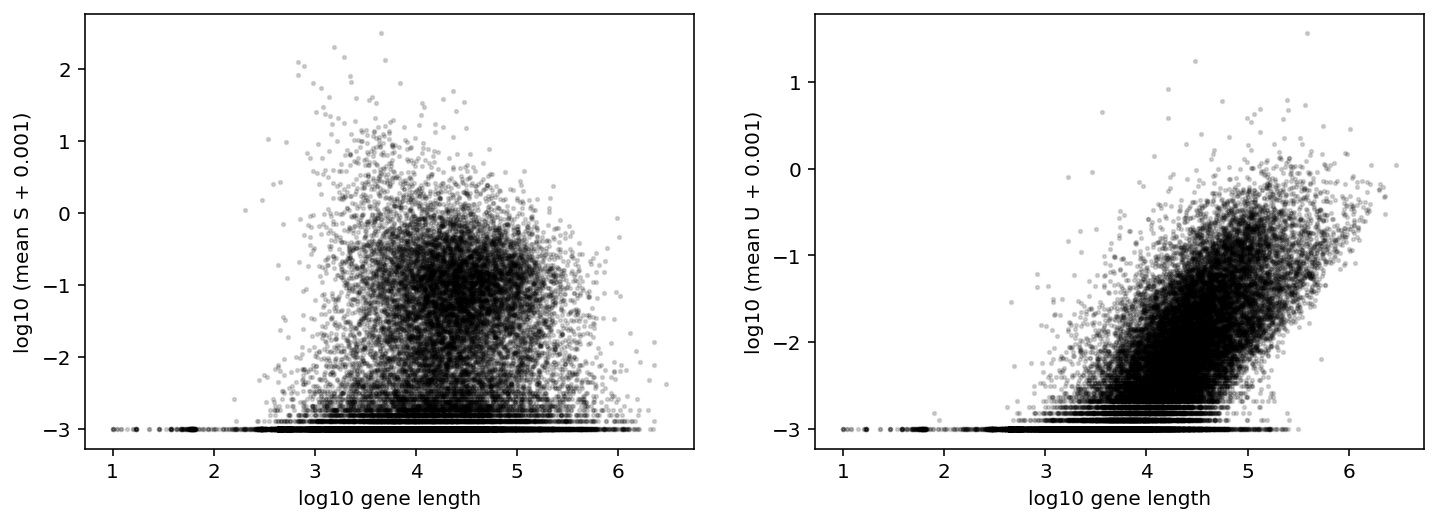

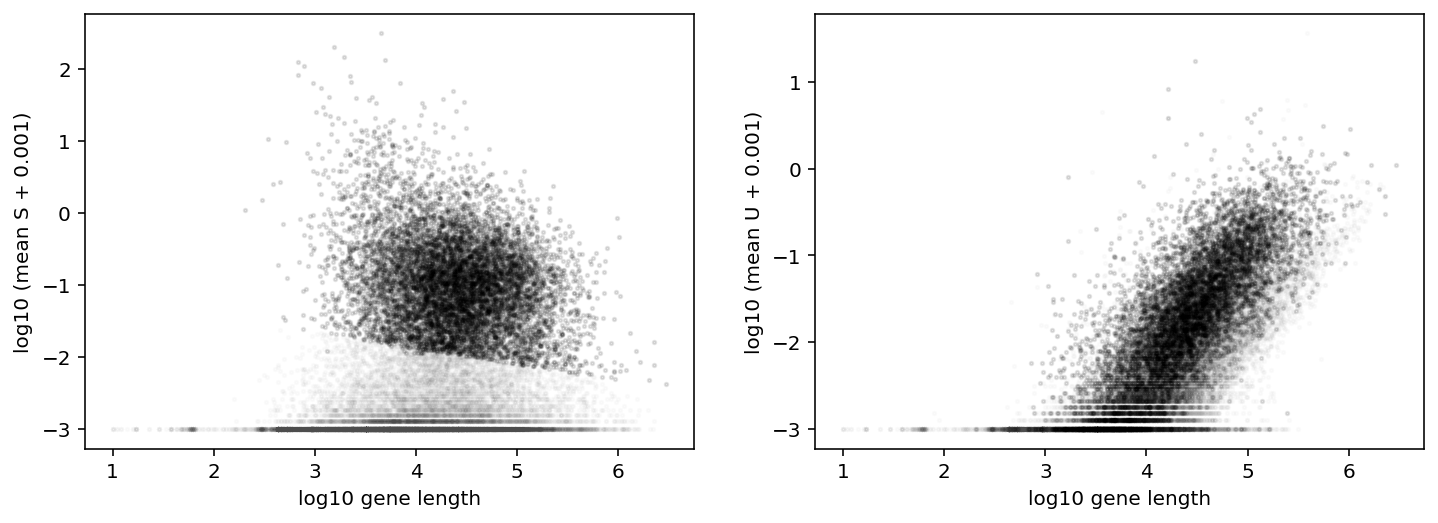

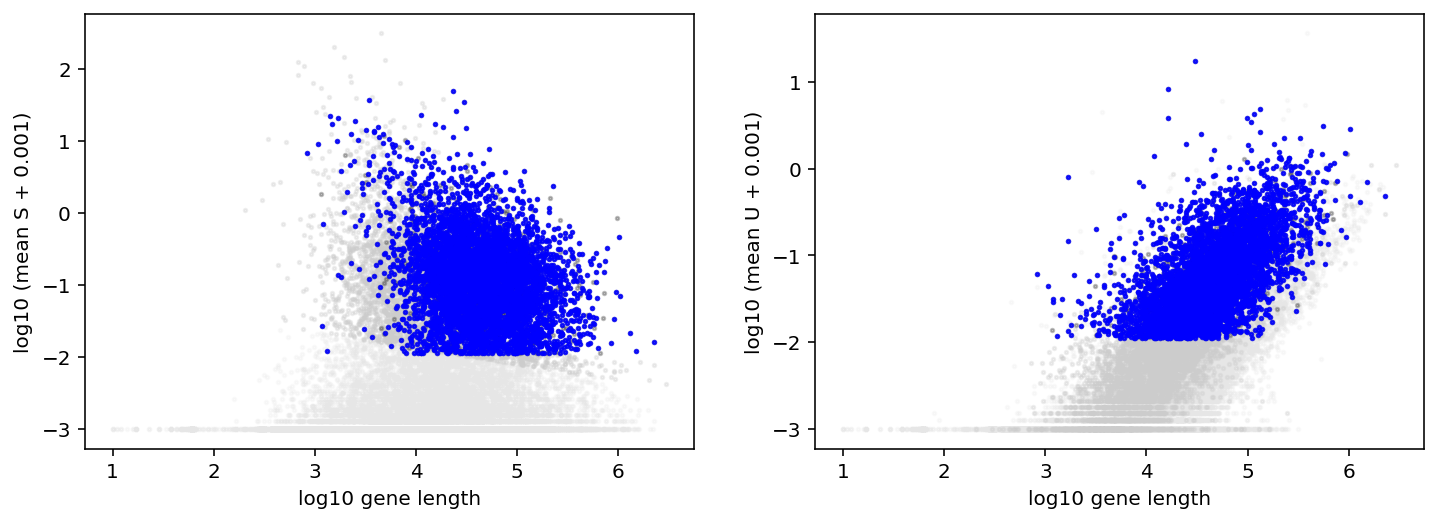

In [46]:
inference_workflow('../example_input_hagC1.txt')

In [12]:
# data_path = '/home/tchari/counts/norman_crispr/loom/'

In [42]:
import loompy as lp
with lp.connect('/home/tchari/counts/hagai_lps/25119_1/counts_filtered/adata_25119_1.loom') as ds:
    print(len(list(ds.ca['barcode'])))
    S = ds.layers["spliced"].sparse().todense()

4835


In [43]:
S.shape

(32285, 4835)

(array([1.5626e+04, 0.0000e+00, 4.9620e+03, 2.9880e+03, 2.4670e+03,
        1.7740e+03, 1.8420e+03, 8.3300e+02, 5.8400e+02, 3.9700e+02,
        2.1000e+02, 1.7000e+02, 1.0500e+02, 7.1000e+01, 5.7000e+01,
        3.9000e+01, 4.3000e+01, 3.5000e+01, 2.0000e+01, 2.0000e+01,
        1.6000e+01, 6.0000e+00, 0.0000e+00, 6.0000e+00, 3.0000e+00,
        2.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.12088143, 0.24176286, 0.36264428, 0.48352572,
        0.60440713, 0.72528857, 0.84617   , 0.96705145, 1.0879328 ,
        1.2088143 , 1.3296957 , 1.4505771 , 1.5714586 , 1.69234   ,
        1.8132215 , 1.9341029 , 2.0549843 , 2.1758657 , 2.2967472 ,
        2.4176285 , 2.53851   , 2.6593914 , 2.780273  , 2.9011543 ,
        3.0220358 , 3.1429172 , 3.2637987 , 3.38468   , 3.5055616 ,
        3.626443  ], dtype=float32),
 <BarContainer object of 30 artists>)

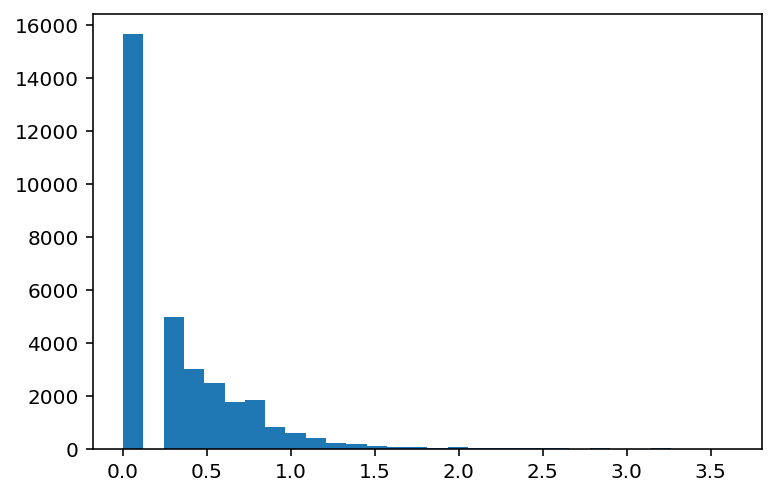

In [44]:
plt.hist(np.log10(S.max(1)+1),30)

['/home/tchari/counts/hagai_lps/25119_1/counts_filtered/adata_25119_1.loom']
Beginning search routine.
32285 features observed, 32005 match genome annotations. 31649 are unique. 
4835 cells detected.
Directory /home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_25119_1_10x11_5000gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...


/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.cli

Parallelization done!


/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])


Runtime: 16.3 min.


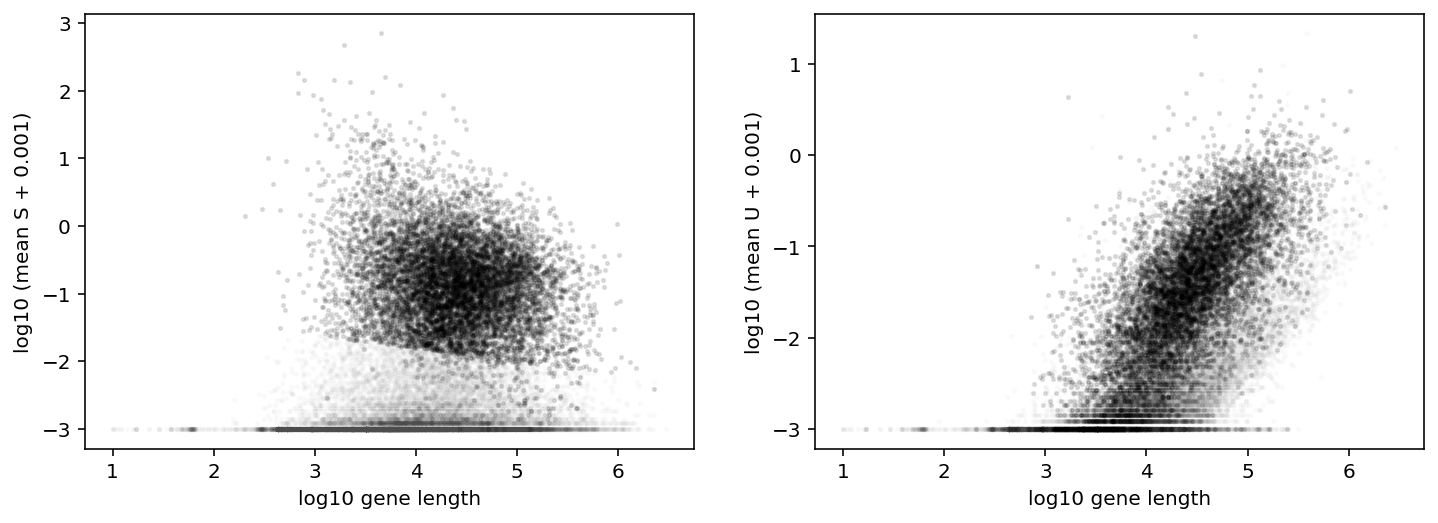

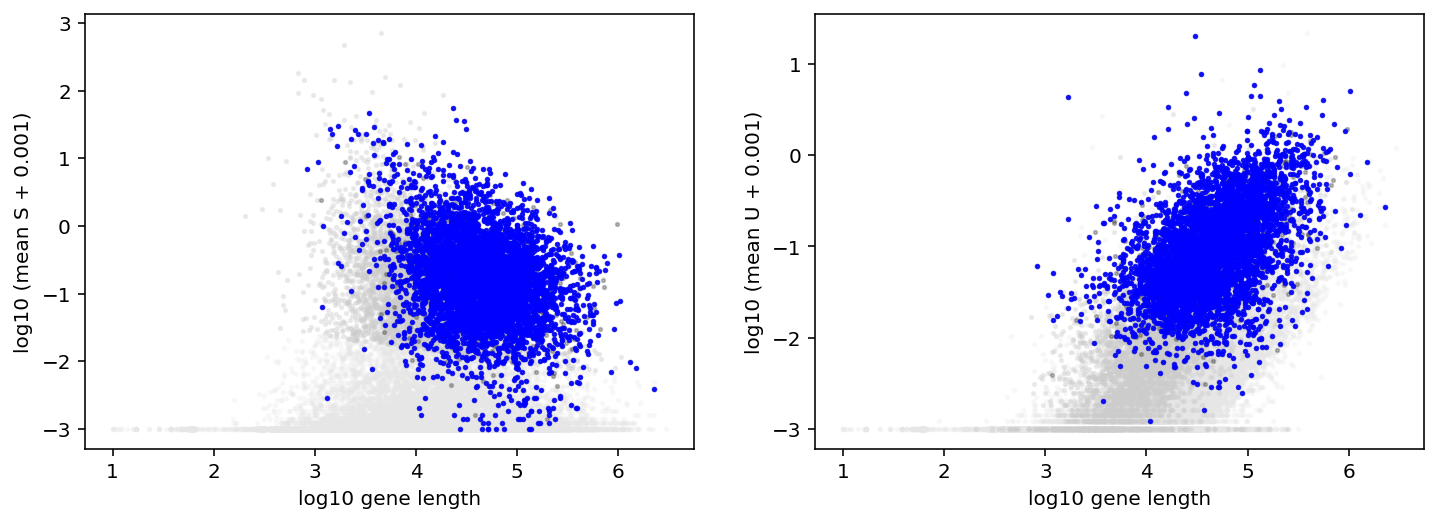

In [47]:
inference_workflow('../example_input_hagC2.txt')

In [ ]:
### Test one of the perturbed populations, CEBPE_RUNX1T1__CEBPE_RUNX1T1
inference_workflow('../example_input_hagLPS6_1.txt')

['/home/tchari/counts/hagai_lps/25119_4/counts_filtered/adata_25119_4.loom']
Beginning search routine.
32285 features observed, 32005 match genome annotations. 31649 are unique. 
4977 cells detected.
Directory /home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_25119_4_10x11_5000gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...


/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])
/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.cli

Parallelization done!


/home/tchari/perturbCME/notebooks/seq_cme_inference.py:901: RuntimeWarning: divide by zero encountered in double_scalars
  gam = np.clip(b * samp[1] / mean_S, lb[2], ub[2])


Runtime: 16.8 min.


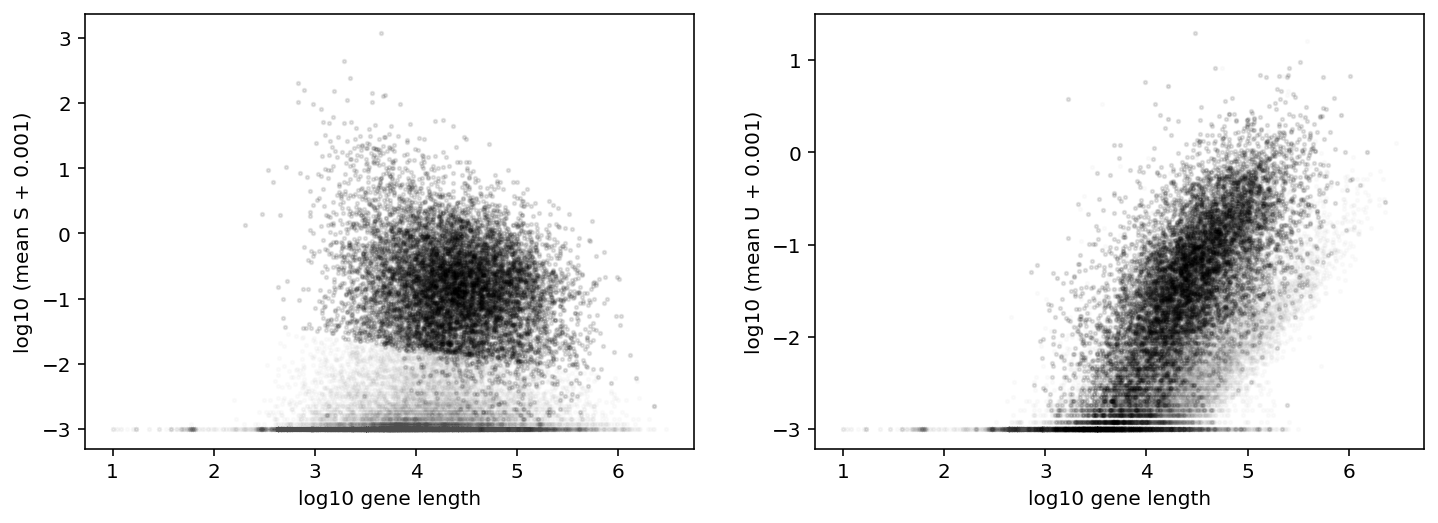

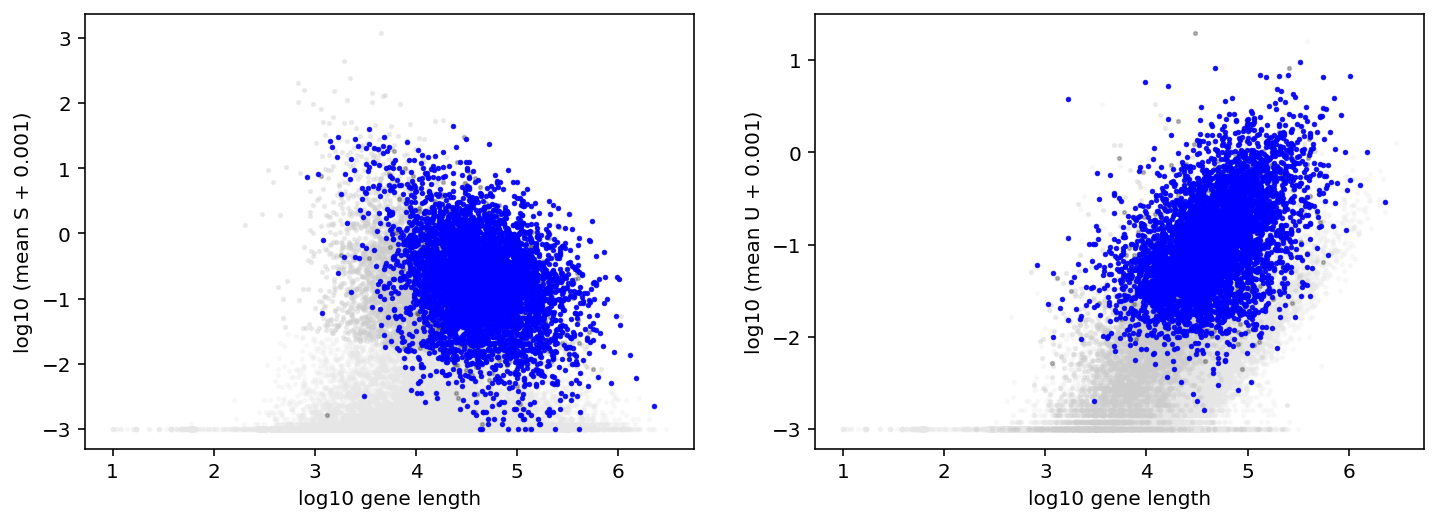

In [7]:
#Test one of the perturbed populations, CEBPE_RUNX1T1__CEBPE_RUNX1T1
inference_workflow('../example_input_hagLPS6_2.txt')

## Result processing

### Data summary and exploration

Import the results. This interface can accept multiple inputs: for example, it's possible to use the same grid for searches over several sets of genes and integrate them in downstream analysis. The names of the strings in the list should be in the format `./result_dir/result.pickle`. 

In [8]:
# a e s t h e t i c s

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

In [9]:
def import_precomputed_(filestring):
    with open(filestring,'rb') as f:
        precomp = pickle.load(f)
    return precomp

def check_at_bounds(result_data,phys_params,thr=0.01):
    x = np.any(np.logical_or(
        result_data.search_params.lb_log+thr > phys_params,
        result_data.search_params.ub_log-thr < phys_params) ,1)
    return x


In [10]:
data_out = '/home/tchari/counts/hagai_lps/loom_res/'

In [11]:
results = [data_out+'tc_211201_adata_24754_6_10x11_5000gen_1/result.pickle',
           data_out+'tc_211201_adata_25119_1_10x11_5000gen_1/result.pickle',
           data_out+'tc_211201_adata_24754_8_10x11_5000gen_1/result.pickle',
          data_out+'tc_211201_adata_25119_4_10x11_5000gen_1/result.pickle']

rep_pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]

dataset_names = ['Control 1','Control 2','LPS6hr 1','LPS6hr 2']

In [12]:
#Read in outputs
result_data_0 = import_datasets([results[0]])
result_data_1 = import_datasets([results[1]])


result_data_lps6_1 = import_datasets([results[2]])

result_data_lps6_2 = import_datasets([results[3]])



In [13]:
data = [result_data_0, result_data_1, result_data_lps6_1,result_data_lps6_2]

In [20]:
result_data_0.raw_S.shape

(2000, 3532)

Visualize the sampling parameter landscape. There is clearly an optimal basin in the $C_u, \lambda_s$ space, although the low resolution of the scan and the  number of genes make it challenging to identify it with much confidence.

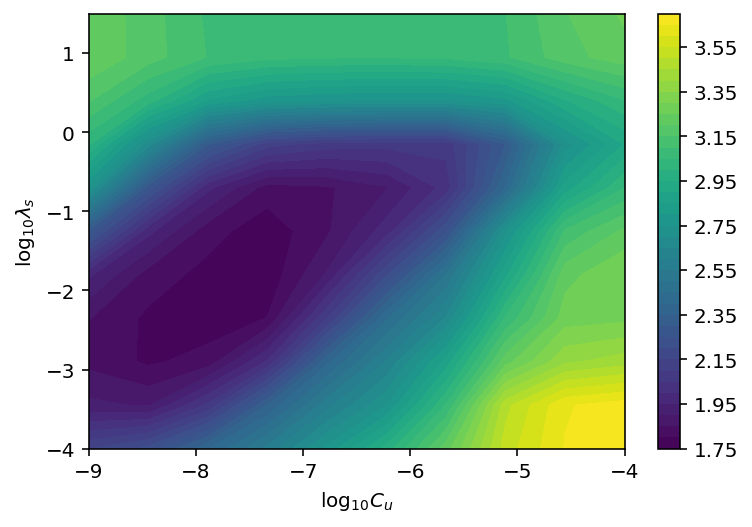

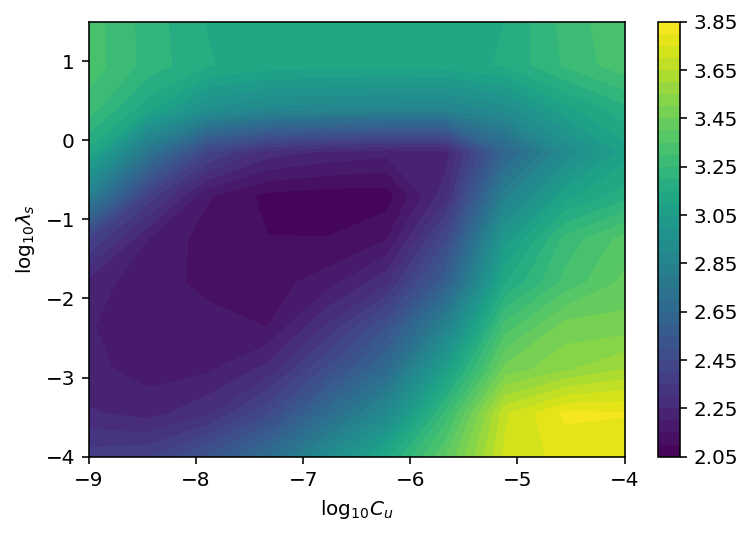

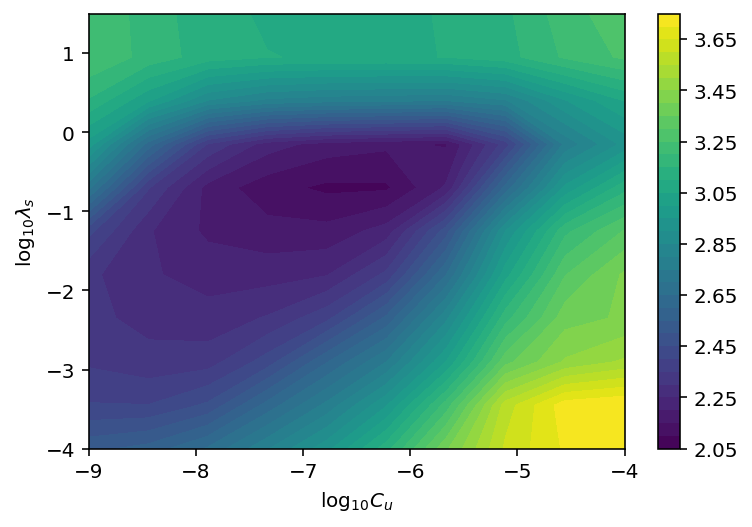

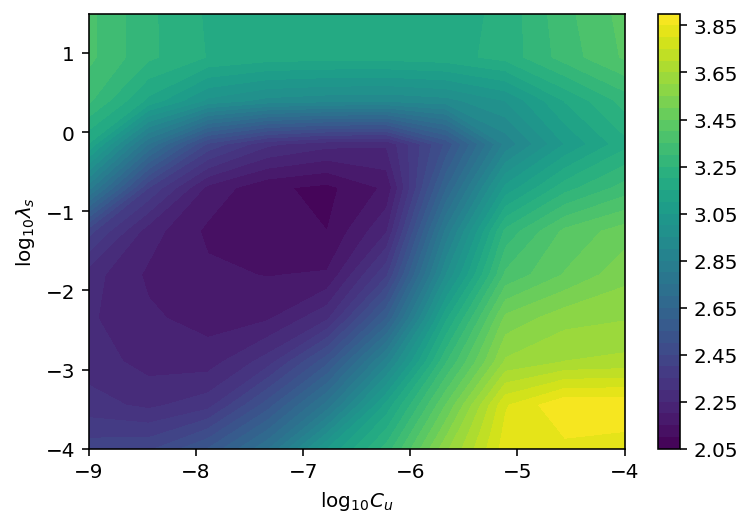

In [14]:
for i in data:
    landscape_viz(i)

Compute the best parameter tuple using simple total KL divergence minimization. 

In [15]:
for i in data:
    i.find_best_params()

In [16]:
for i in data:
    print(i.best_samp_params)


(-7.333333333333333, -1.7999999999999998)
(-6.222222222222222, -0.6999999999999997)
(-6.777777777777778, -0.6999999999999997)
(-6.777777777777778, -0.6999999999999997)


Test the stability of the parameter optimum under resampling. Essentially, we subsample sets of genes and see how the landscape and its optimum change. The basin appears to be robust and well-defined with as few as 20 genes.

In [18]:
resamp_vec = np.array(np.linspace(0,result_data_0.n_gen,6)[1:-1],dtype=int)

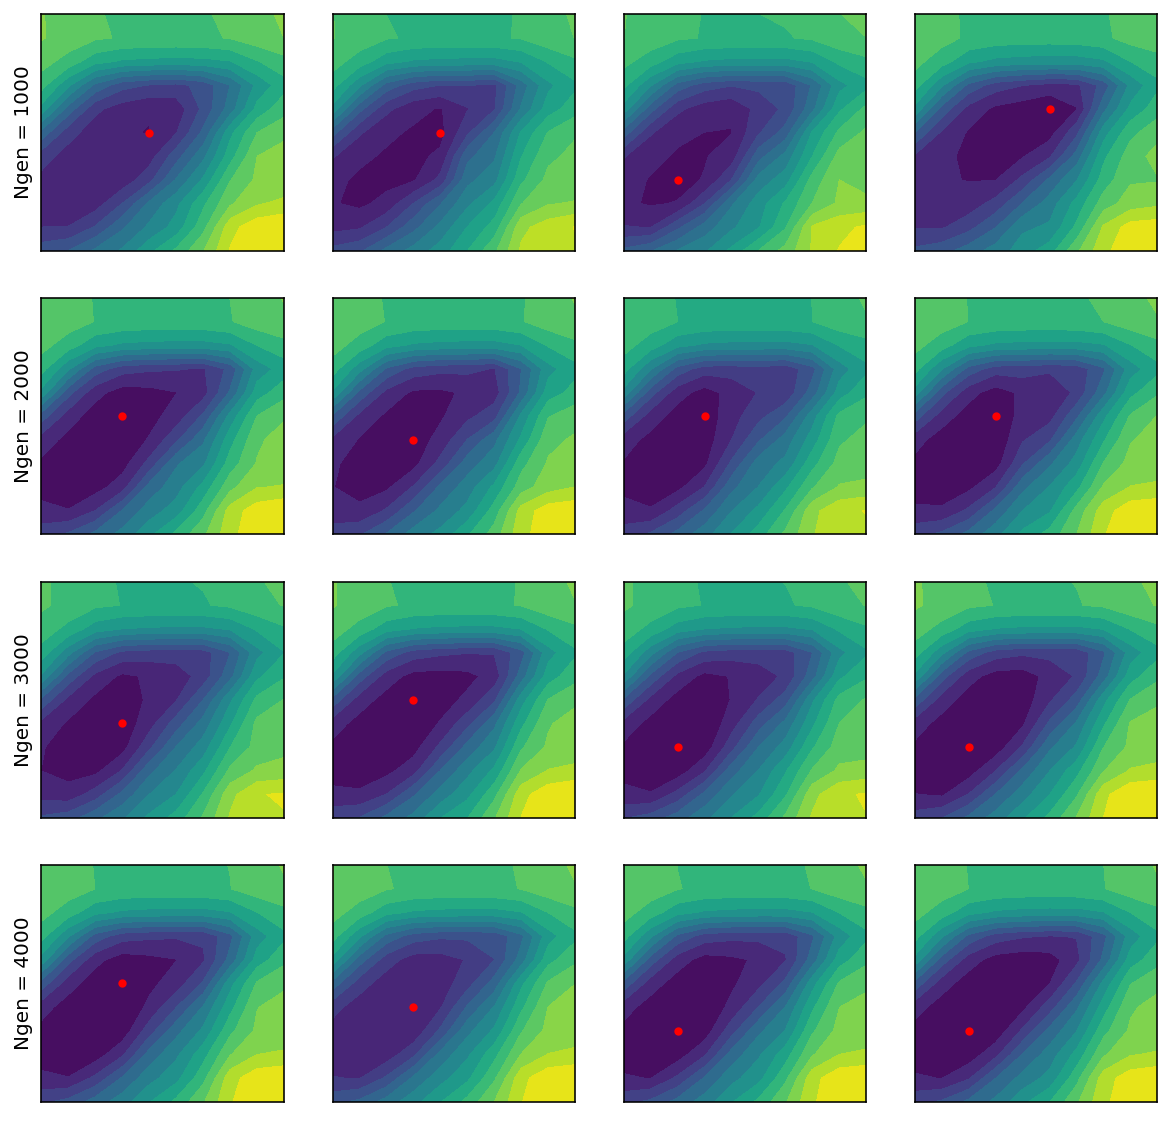

In [19]:
resample_opt_viz(result_data_0,resamp_vec)

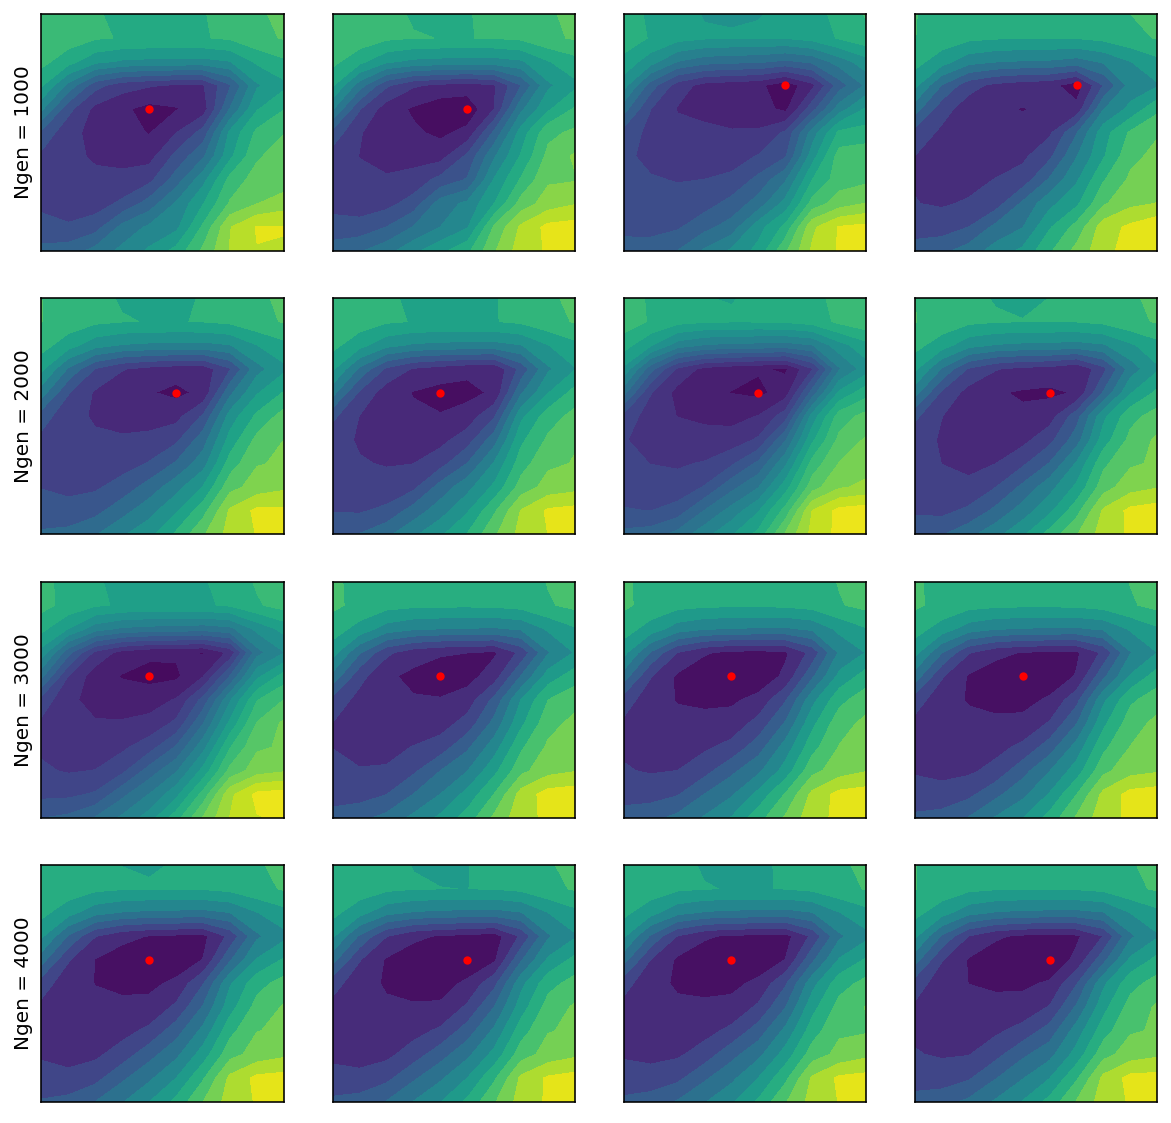

In [20]:
resample_opt_viz(result_data_lps6_1,resamp_vec)

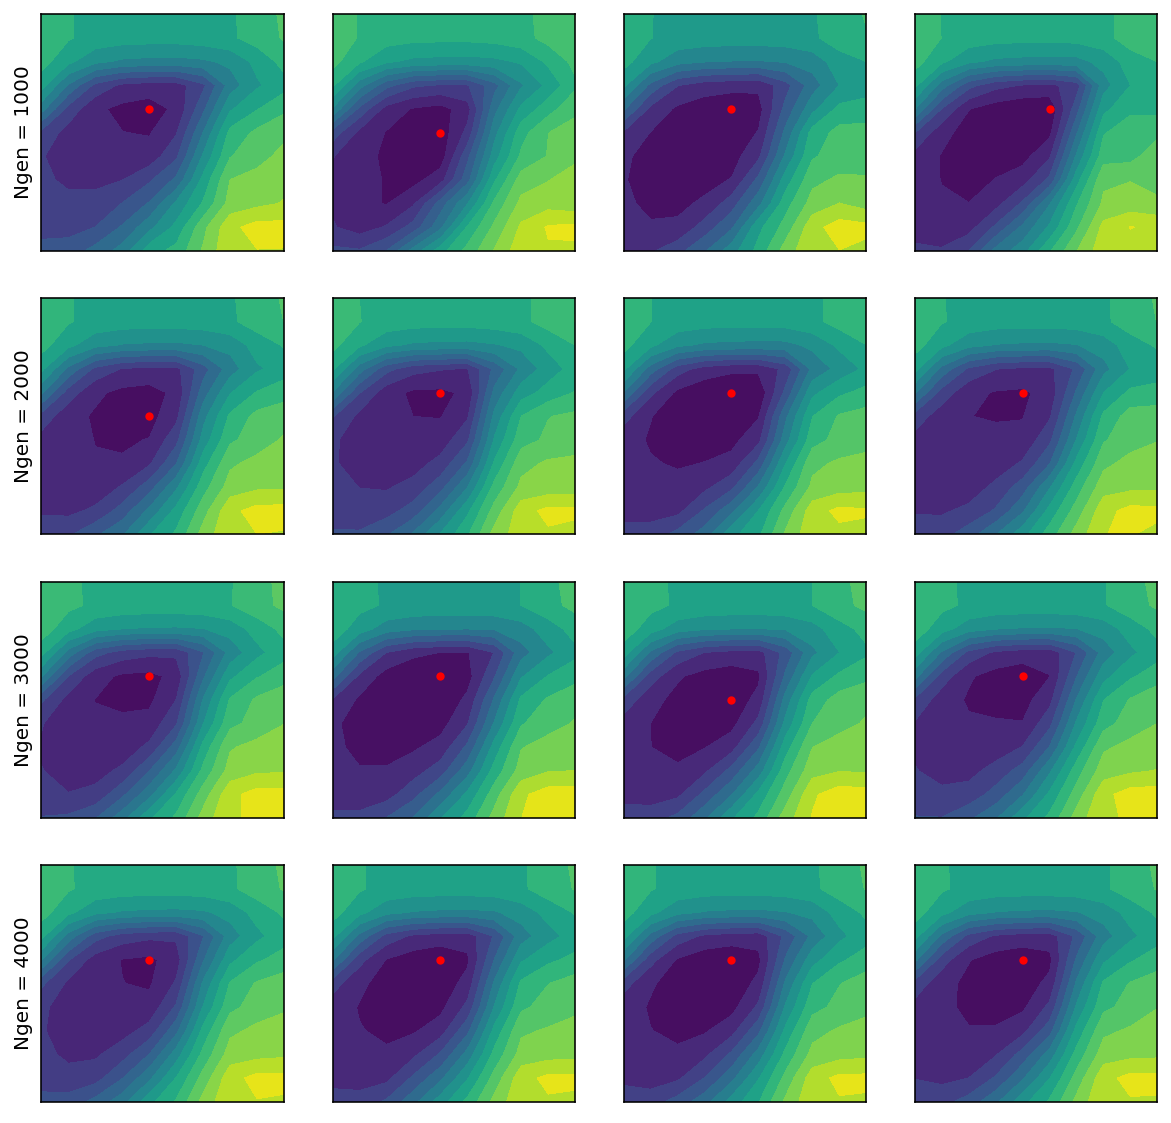

In [21]:
resample_opt_viz(result_data_lps6_2,resamp_vec)

Summarize these findings by resampling 1000 times and plotting the locations of the optima.

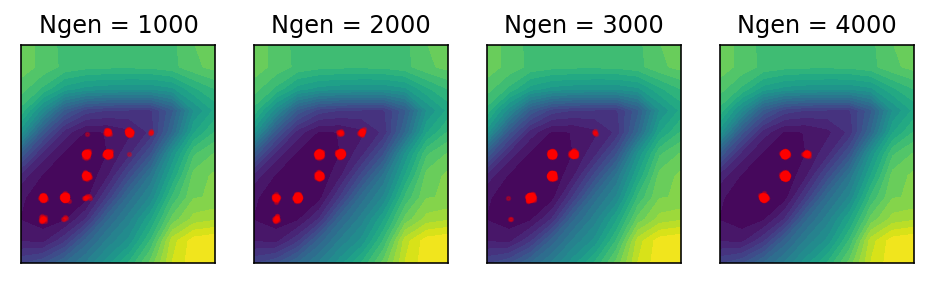

In [22]:
resample_opt_mc_viz(result_data_0,resamp_vec)

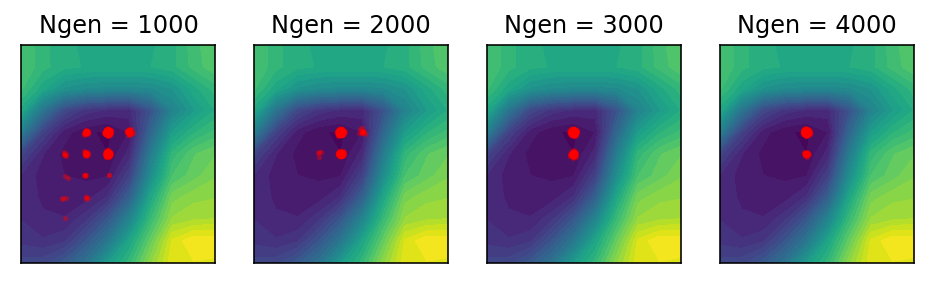

In [24]:
resample_opt_mc_viz(result_data_lps6_2,resamp_vec)

Plot a normal-inverse Gaussian fit to the parameters, with and without sampling. The parameters clearly show quite a bit of skewness.

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1833: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4156: RuntimeWarning: invalid value encountered in multiply
  return fac1 * sc.k1e(a * sq) * np.exp(b*x - a*sq) / sq
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python

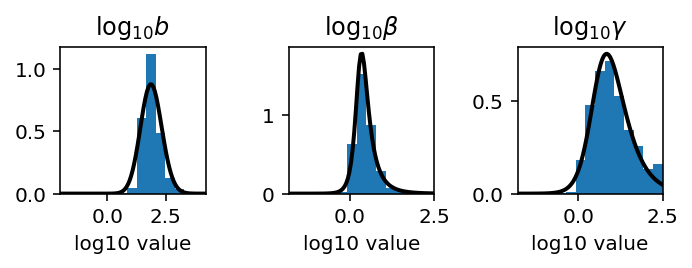

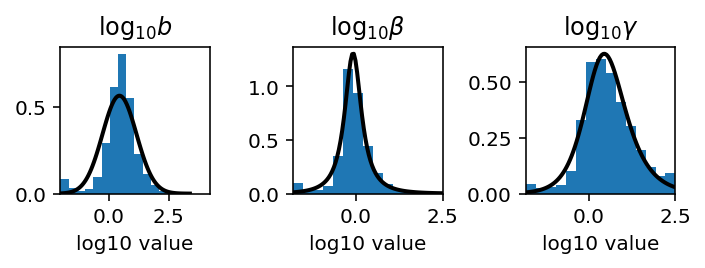

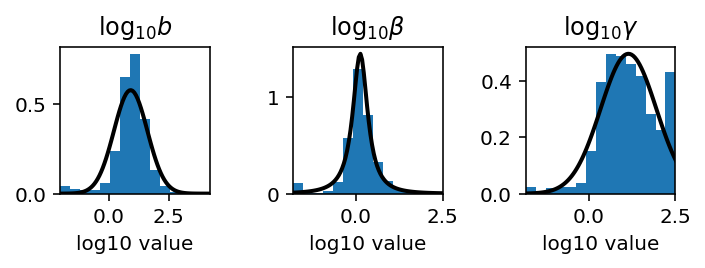

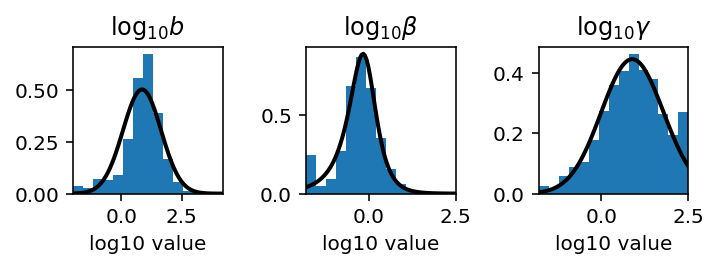

In [25]:
from scipy.stats import *
for i in data:
  plot_param_marg(i,fitlaw=norminvgauss)

Perform the same analysis on the noise-free results. The burst size parameters are shifted down by roughly an order of magnitude.

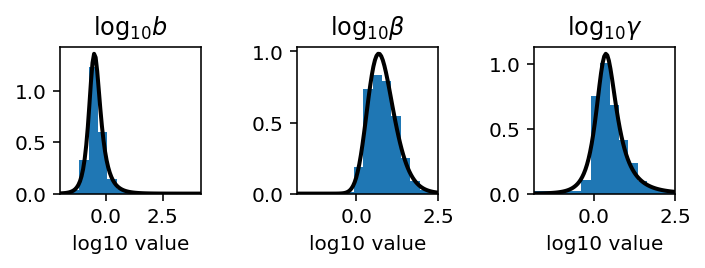

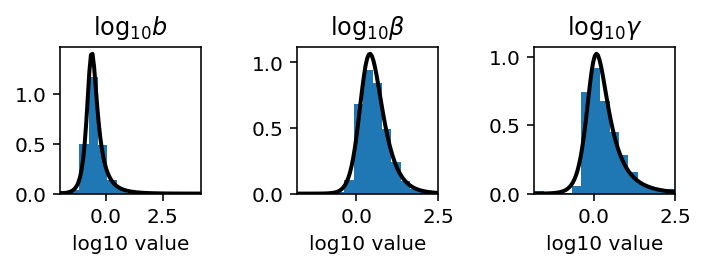

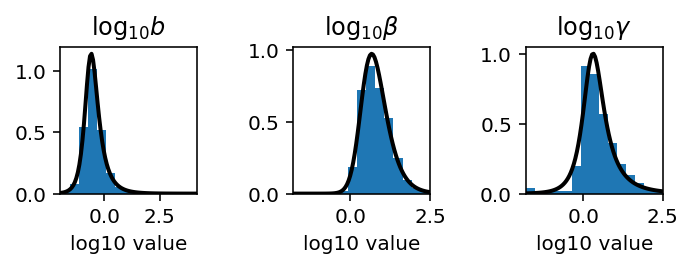

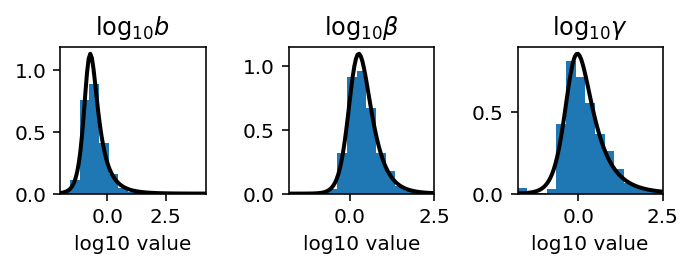

In [26]:
for i in data:
  plot_param_marg(i,nosamp=True,fitlaw=norminvgauss)

Examine length dependence (without error bars on maximum likelihood estimates). The full technical noise model does not appear to show much length dependence -- apart from, perhaps, a very modest decrease in burst size. The noise-free model shows that the burst size increases with length.

In [57]:
# fo
# result_data_0.best_phys_params
# params_1 = result_data_1.best_phys_params
# params_both = result_data_both.best_phys_params

In [27]:
for i in data:
    chisq_gen(i)
    compute_sigma(i)

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 21 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 61 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 83 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 573 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 584 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 603 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 1952 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 2247 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 2420 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 2460 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 2712 gives nega

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 3 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 373 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 425 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 438 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 530 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 603 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 622 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 666 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 677 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 764 gives negative 

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 7 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 15 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 80 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 83 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 155 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 161 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 181 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 328 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 389 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 436 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 525 gives negative st

Parameter set 3 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 14 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 80 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 83 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 255 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 257 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 294 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 345 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 425 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 436 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 445 gives negative st

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


In [28]:
from matplotlib.colors import ListedColormap
c_highlight = col_red
c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=20
cmap = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

/home/tchari/counts/hagai_lps/loom_res/tc_211130_adata_24754_6_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_25119_1_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211130_adata_24754_6_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_24754_8_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211130_adata_24754_6_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_25119_4_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_25119_1_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_24754_8_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_25119_1_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_25119_4_10x11_5000gen_1/result.pickle
/home/tchari/counts/hagai_lps/loom_res/tc_211201_adata_24754_8_10x11_5

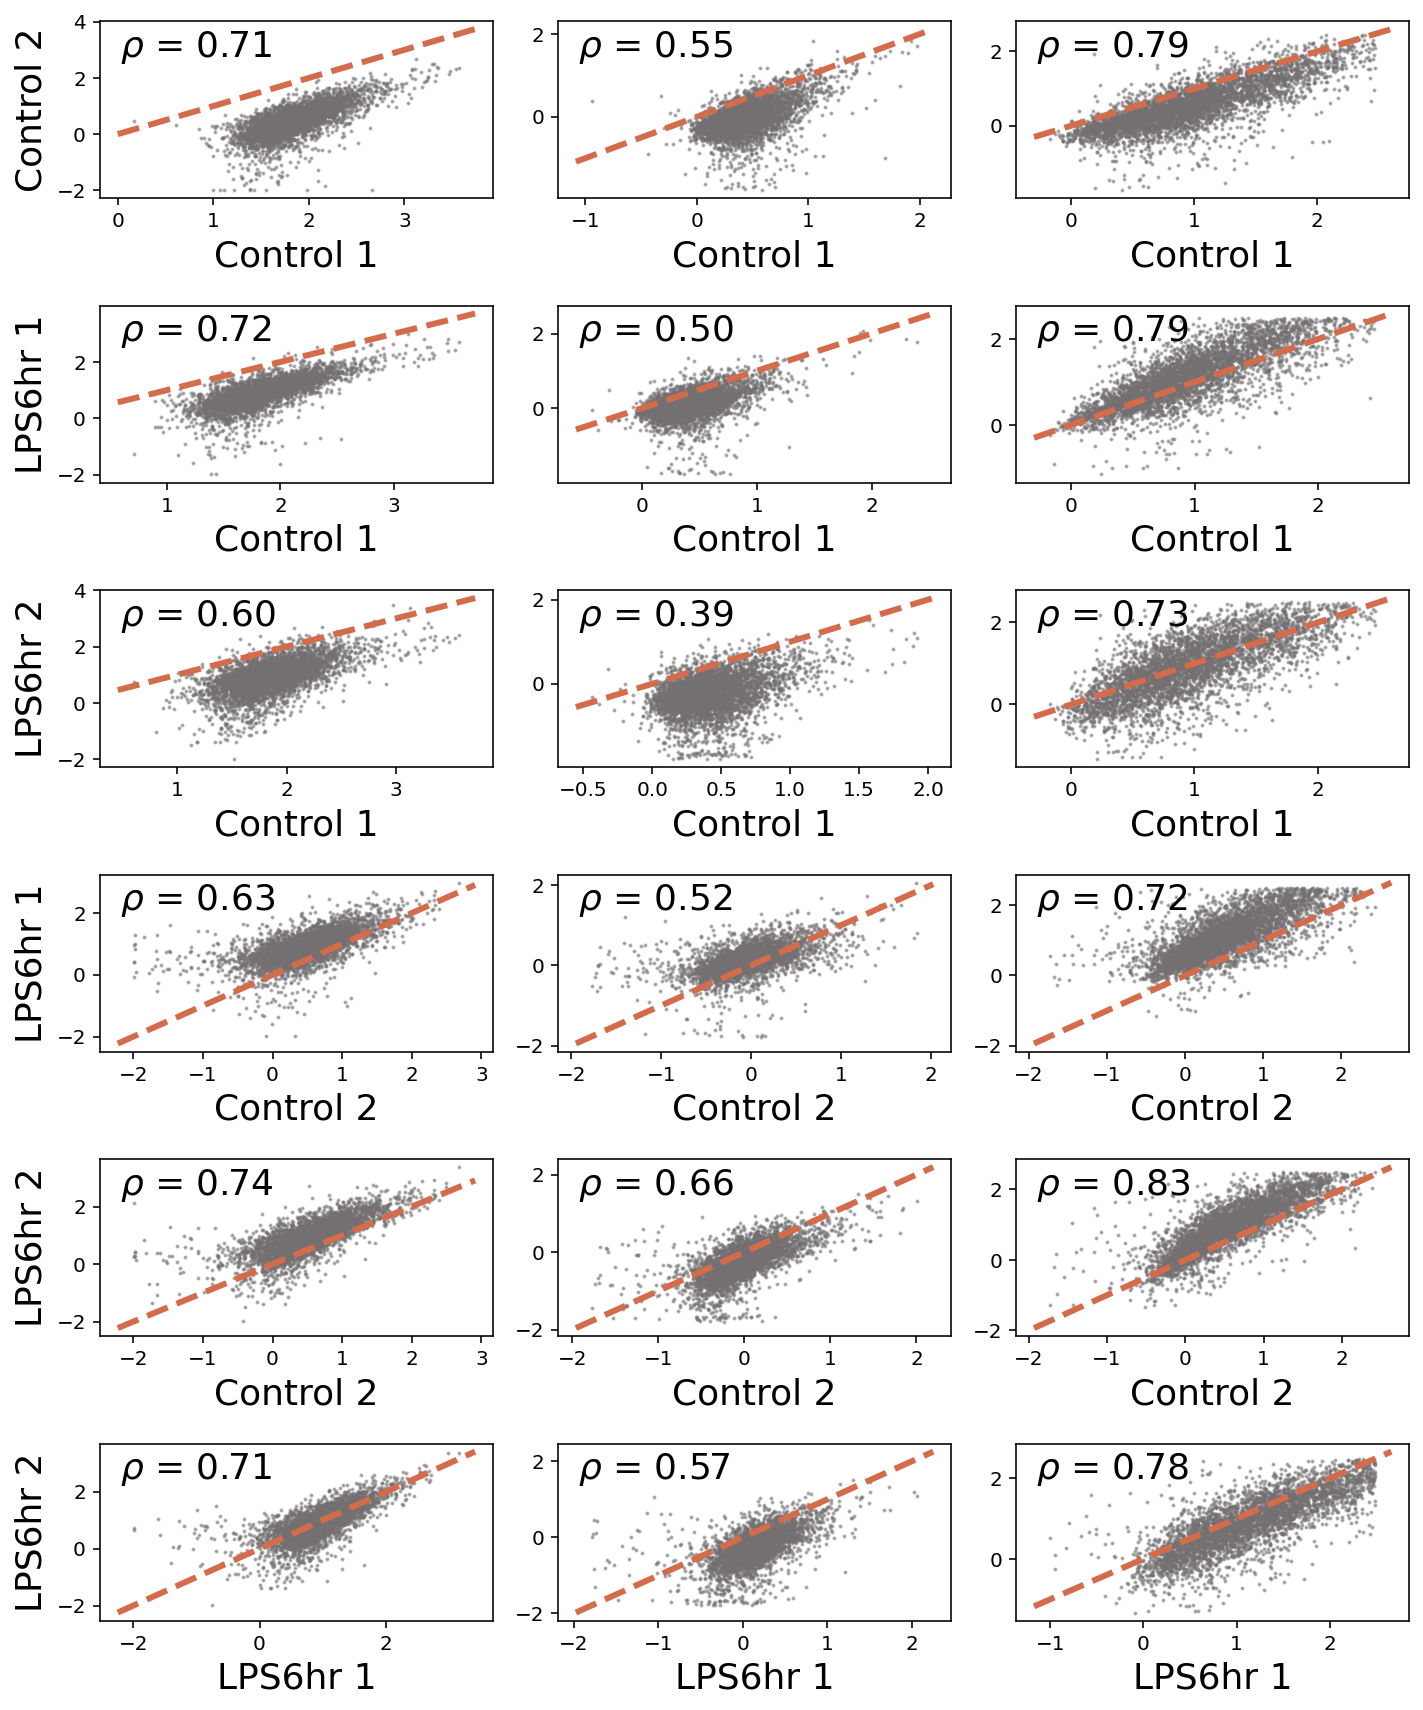

In [34]:
ms,lw,ms_fail,alf,alf_fail = sifig_aesth
fig1, ax1 = plt.subplots(nrows=len(rep_pairs),ncols=3,figsize=(10,12))
nbin=30
for i in range(len(rep_pairs)):
    K = rep_pairs[i]
    print(results[K[0]])
    res1 = data[K[0]]#import_precomputed_(results[K[0]])


    print(results[K[1]])
    res2 = data[K[1]]#import_precomputed_(results[K[1]])
    #chisq_gen(res2)

    err1 = res1.sigma*2.576
    err2 = res2.sigma*2.576


    for j in range(3):
        filt = ~res1.gene_rej & ~res2.gene_rej \
            & ~check_at_bounds(res1,res1.best_phys_params)\
            & ~check_at_bounds(res2,res2.best_phys_params)
#         ax1[i,j].errorbar(res1.best_phys_params[filt,j],
#             res2.best_phys_params[filt,j],
#             err1[filt,j],err2[filt,j],marker=markerstyle,ms=ms,c=col_gold,alpha=alf,linestyle='None',linewidth=lw,zorder=-100)
        ax1[i,j].scatter(res1.best_phys_params[filt,j],
                   res2.best_phys_params[filt,j],color=col_gray,alpha=alf_fail,s=ms_fail)


        fs=18
        rho=np.corrcoef(res1.best_phys_params[filt,j],res2.best_phys_params[filt,j])[0][1]
        xl = ax1[i,j].get_xlim()
        ax1[i,j].plot(xl,xl,'--',color=c_highlight,linewidth=3)
        ax1[i,j].set_xlabel(dataset_names[K[0]],fontsize=fs)

        if j==0:
            ax1[i,j].set_ylabel(dataset_names[K[1]],fontsize=fs)
        ax1[i,j].text(.05,.8,r'$\rho$ = {:.2f}'.format(rho),fontsize=fs,transform=ax1[i,j].transAxes)

fig1.tight_layout()
fig1.show()

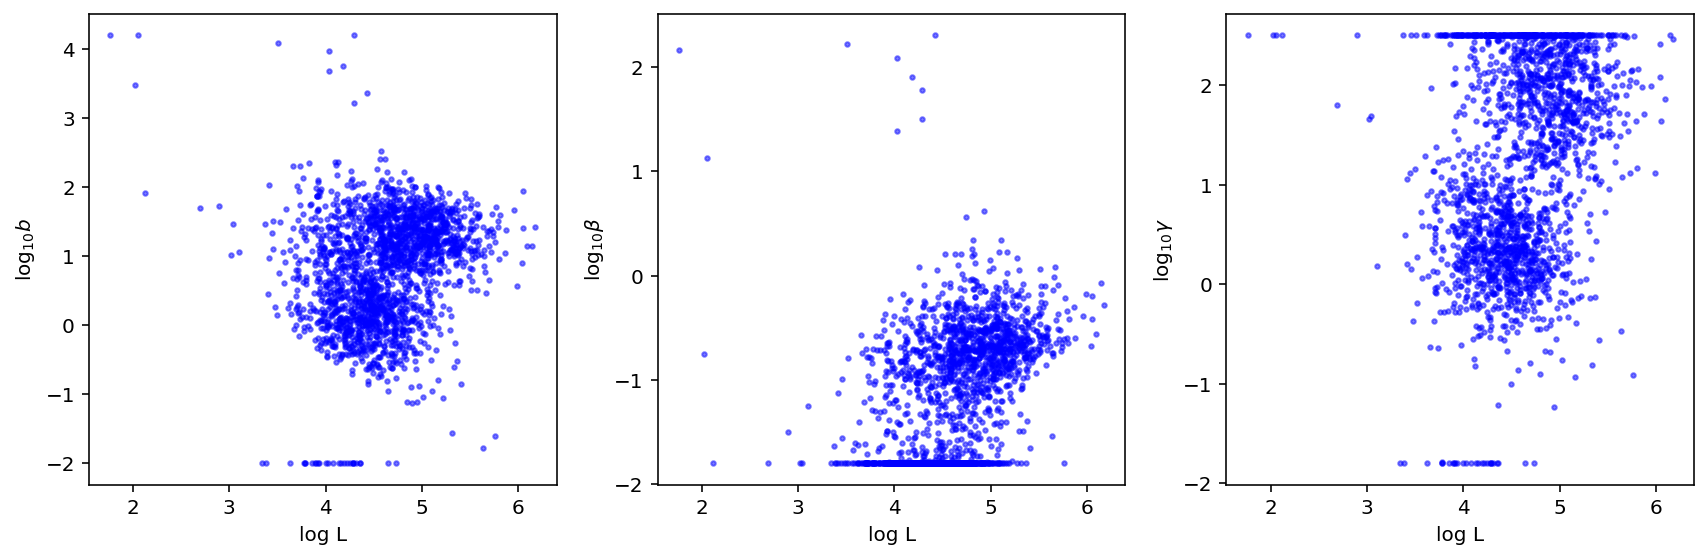

In [33]:
plot_param_L_dep(result_data_0,plot_errorbars=False)

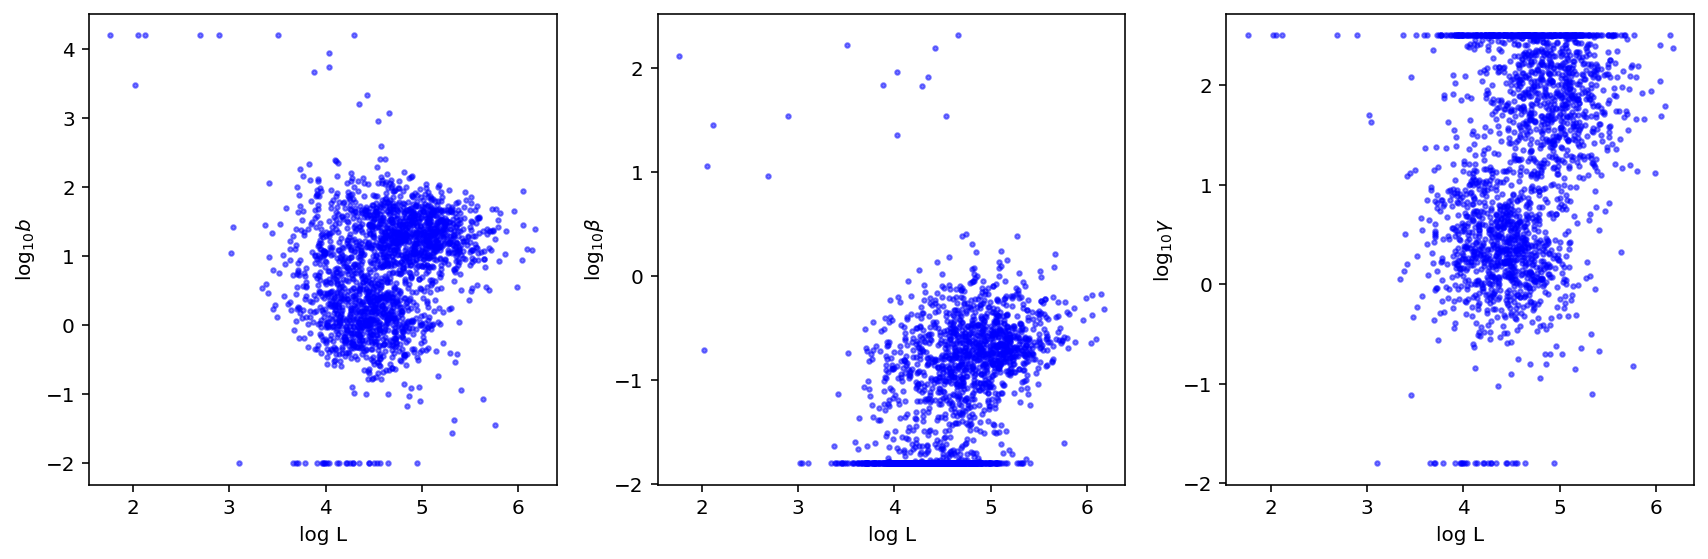

In [34]:
plot_param_L_dep(result_data_1,plot_errorbars=False)

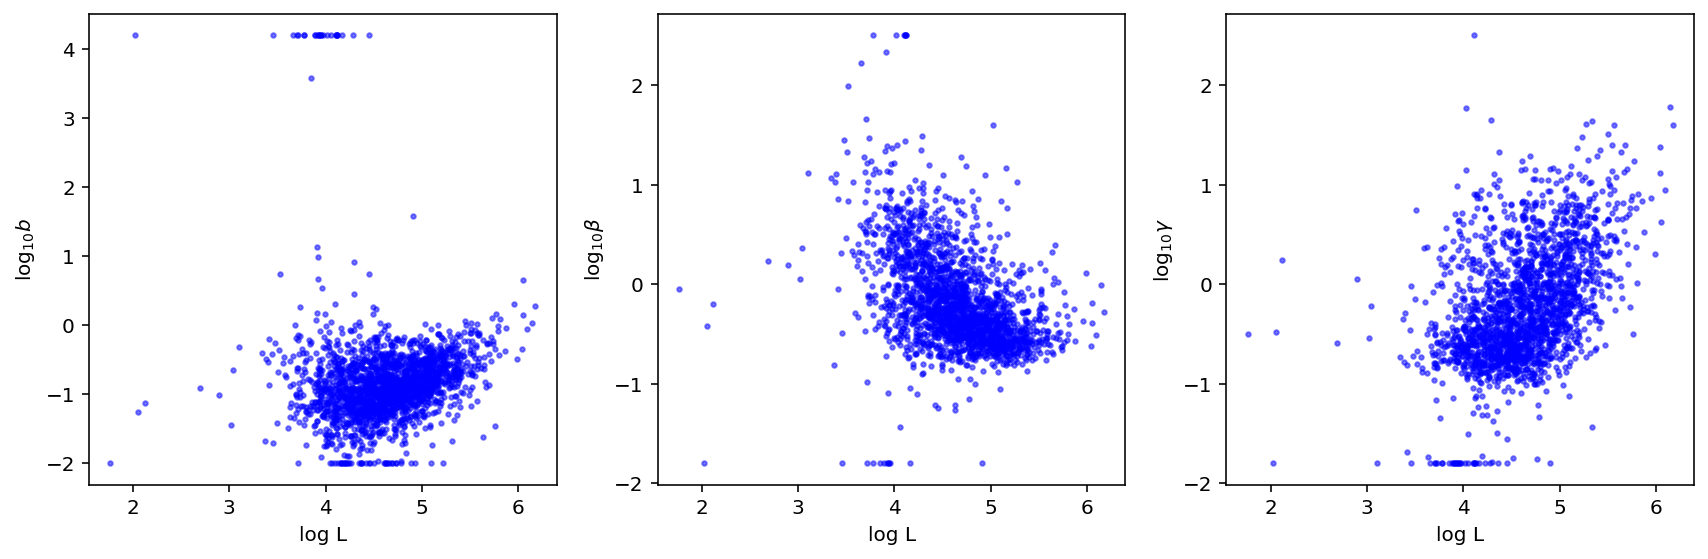

In [36]:
plot_param_L_dep(result_data_0,plot_errorbars=False,nosamp=True,chisq_correct=False)

### Fit quality analysis

Investigate the distribution of KL divergences at the optimal grid point. Only a few genes seem to have obviously poor fits (high KL divergence).

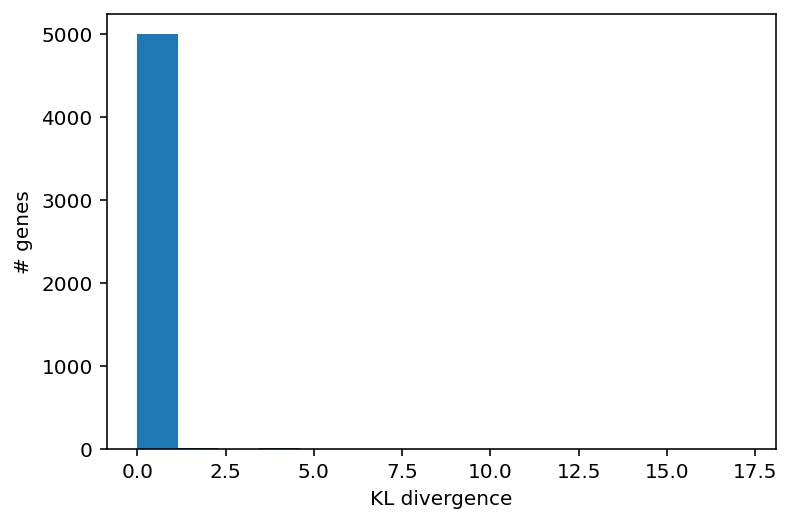

In [36]:
plot_KL(result_data_1)

Compute the chi-squared statistic and $p$-values for all genes at the optimal grid point.

In [38]:
(chisq,pval) = chisq_gen(result_data_0)

Is the $p$-value higher than 0.05/`n_gen`? The gene is retained. Lower? The gene is rejected due to potential model misspecification.

Output results of the chi-square test in an array corresponding to 1 = rejected, 0 = not rejected.


In [31]:
sz = (50,100) 
figsize = (10,5)
title=True

In [42]:
print(np.array(np.reshape(result_data_0.gene_rej,sz),dtype=int))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [43]:
print(str(np.sum(result_data_0.gene_rej))+' genes of '+str(result_data_0.n_gen)+' have been rejected by chi-square.')

134 genes of 2000 have been rejected by chi-square.


Compare the actual raw data to the fits (points: raw data, contour plot: theoretical PMF). The fits seem to accurately reconstruct the molecular distributions. The rejected genes are HSPD1, ATRX, SLU7, COPE, and TCF4.

In [ ]:
plot_genes(result_data_1,sz,figsize,'none',log=True,title=False)

Plot the marginals. Again, the fits appear to be fairly good, although the data are sparse. Note the relatively poor fit to COPE, which supports the choice to reject.

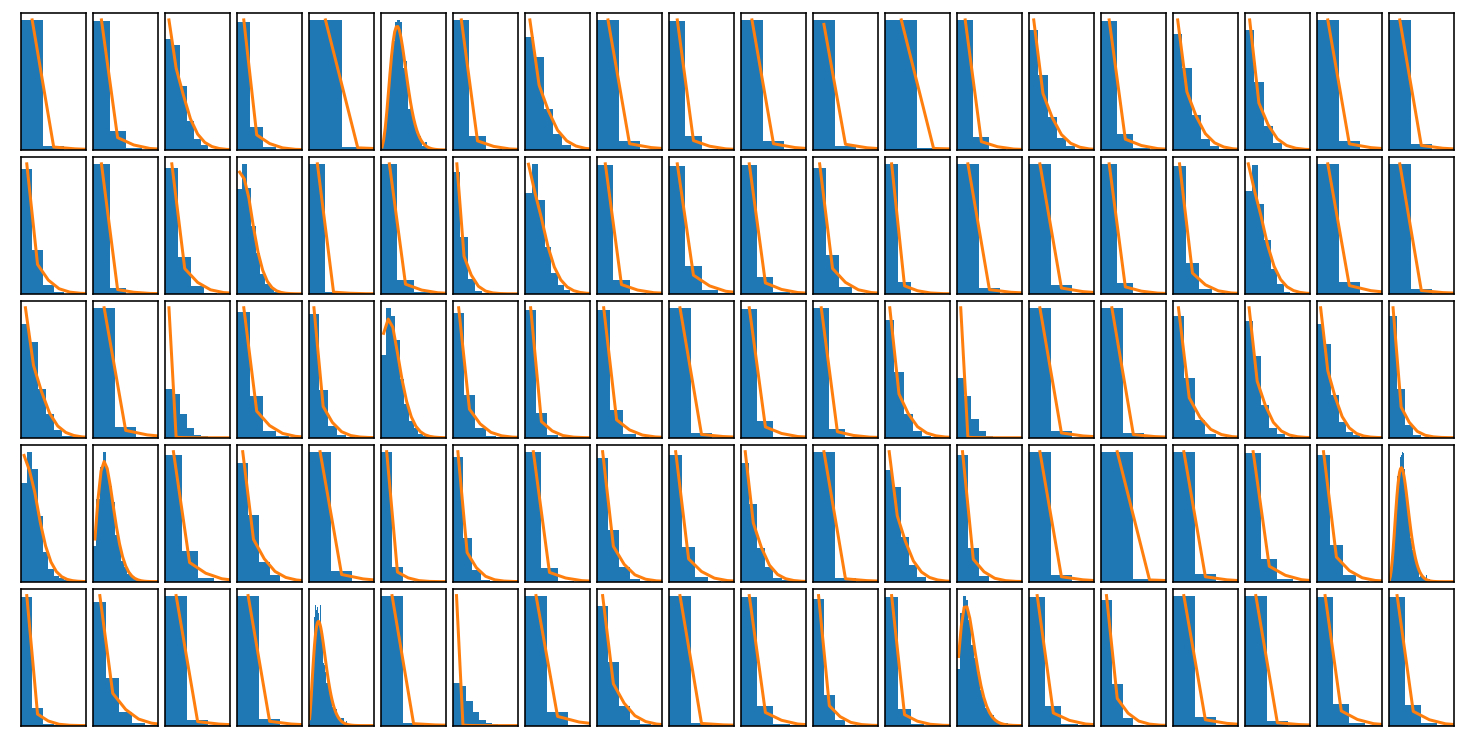

In [55]:
plot_genes(result_data_1,sz,figsize,'mature',log=False,title=False)

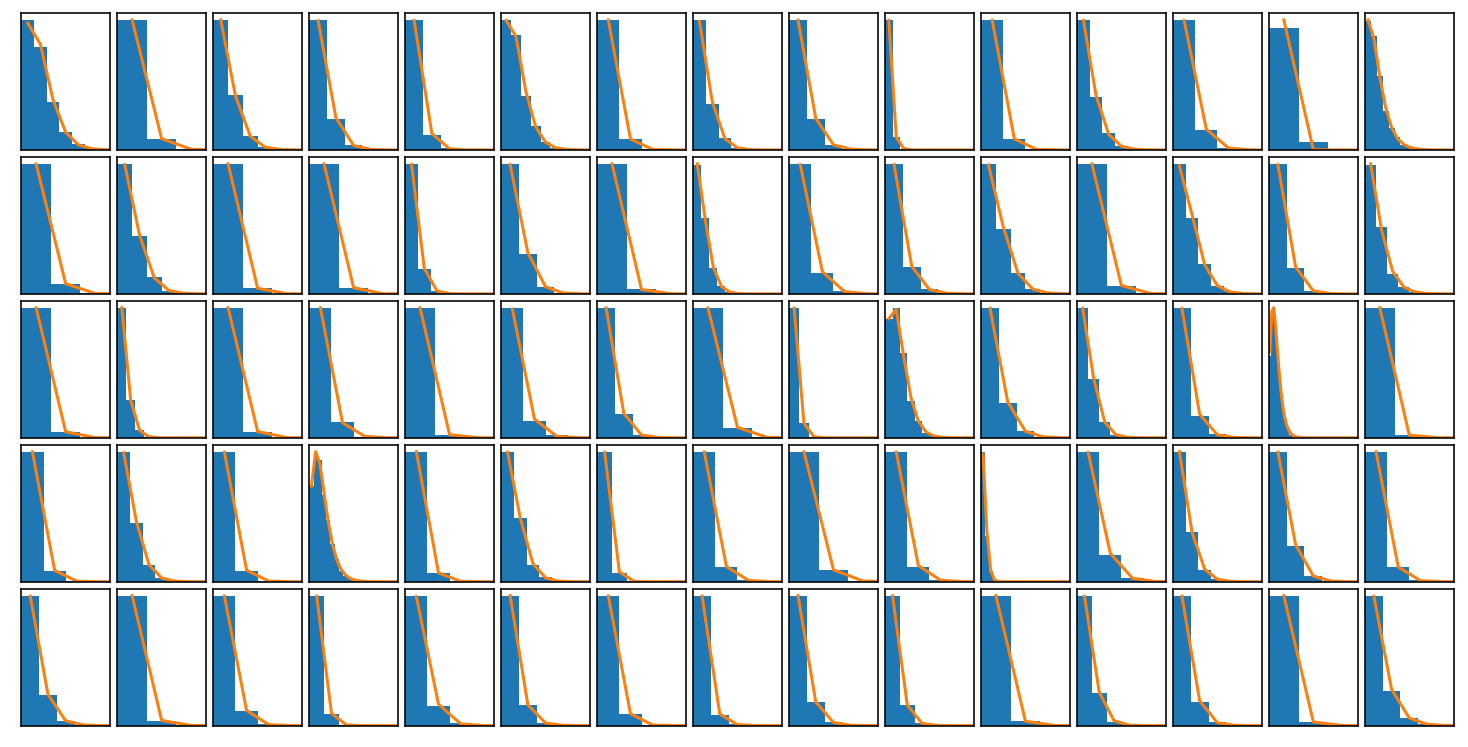

In [ ]:
plot_genes(result_data,sz,figsize,'nascent',log=False,title=False)

Test the stability of the optimum under self-consistent chi-squared testing: reject five genes, recompute the optimum based on all others, repeat. The optimum does not move.

(-7.333333333333333, -0.6999999999999997)

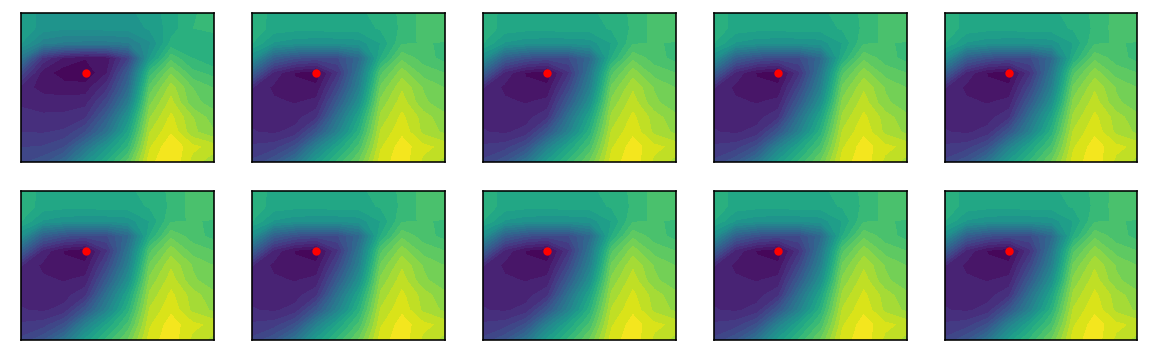

In [46]:
chisq_best_param_correction(result_data_0,overwrite=True)

In [56]:
#0- variance on unspliced 1-mean unspliced (look for over- or under-dispersion)
result_data_1.moment_data[:,0]/result_data_1.moment_data[:,1]-1 

array([ 0.08989863, -0.01018599,  0.11706939,  0.10882785,  0.04046319,
        0.07875034,  0.06437595,  0.85342857,  0.04850345,  0.23837336,
        0.07911191,  1.13818348,  0.01516192,  0.01501023,  0.01359475,
        0.19658519,  0.09890436,  0.07563696,  0.00522107,  0.05365334,
        0.03828089,  0.11063672, -0.00376708,  0.07913028,  0.05293455,
        0.00928353,  0.08971789,  0.02829159,  0.27159441,  0.0779046 ,
        0.15689285,  0.09743607,  0.05325443,  0.05716146,  0.28757898,
        0.0249236 ,  0.23585175,  0.18219112,  0.03989908,  0.17816711,
        0.10383072,  0.10036366, -0.01512222, -0.02283668,  0.22987029,
        0.20329477,  0.28863978,  0.10486817,  0.30487714,  0.22893599,
        0.02362154,  0.55326717,  0.40900592, -0.0105671 ,  0.1200809 ,
        0.15273295,  0.04425839,  0.02623268,  0.15886197,  0.71619177,
        0.23267862,  0.05853857,  0.37903847,  0.59202849,  0.0726365 ,
        0.01411082,  0.25219049,  0.13790723,  0.06592245,  0.09

###Confidence interval construction

Compute conditional 99% confidence intervals for MLEs at the optimal grid point. These are fairly narrow, as there are a lot of cells. The genes rejected by the chi-squared test are excluded. We also plot a linear fit to the parameter trends, computed using weighted linear least squares. 

In [ ]:
compute_sigma(result_data)
compute_sigma(result_data,nosamp=True)

/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 37 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 24 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 45 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


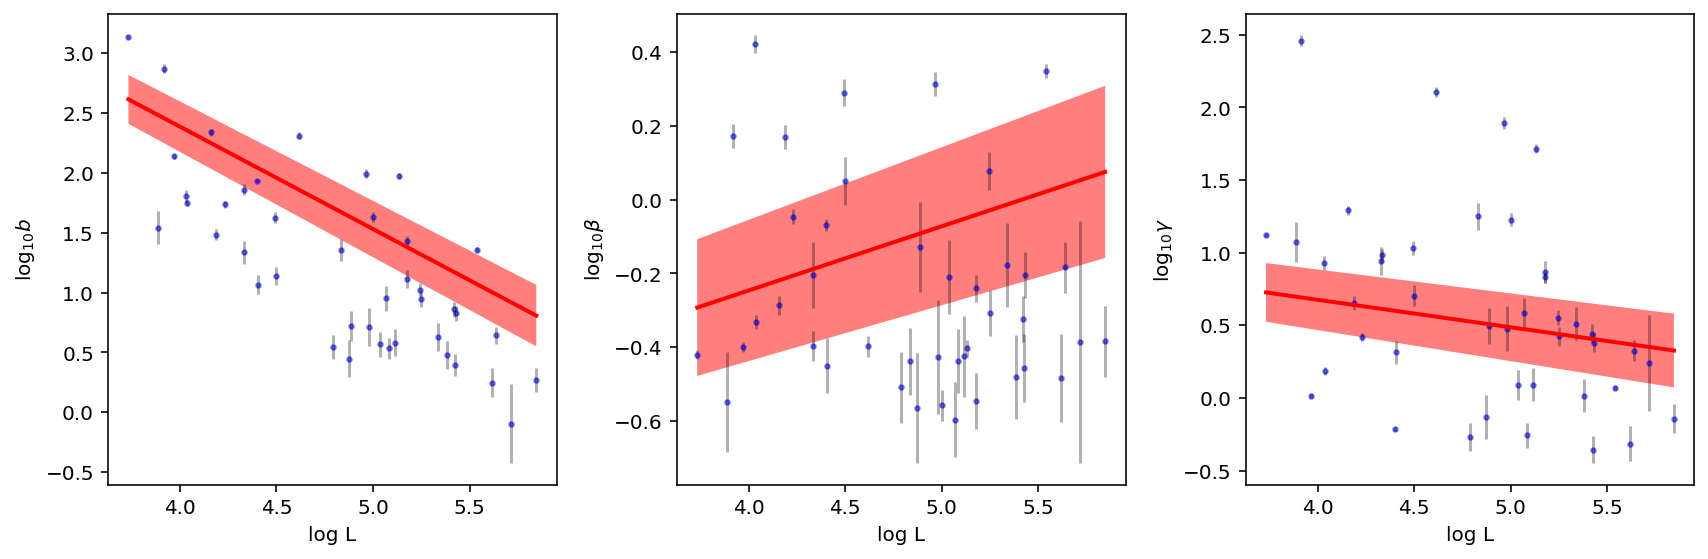

In [ ]:
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=False)

We repeat the procedure for the noise-free fit.

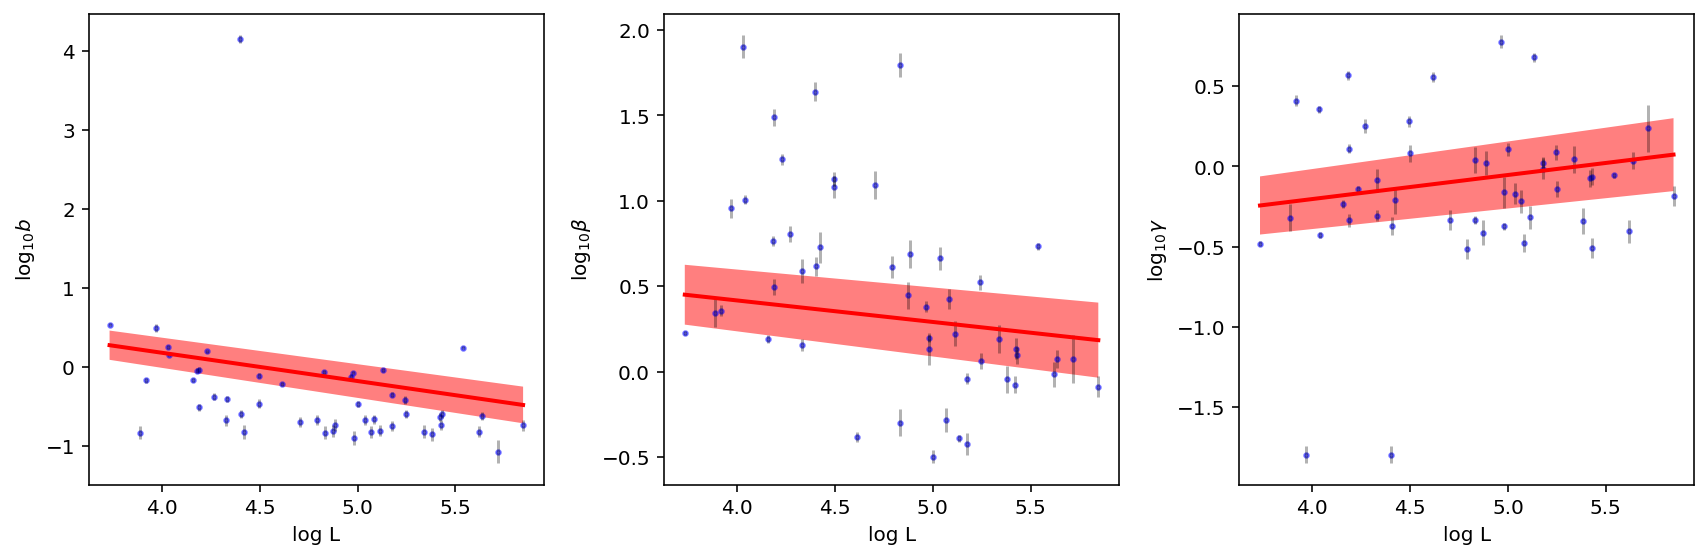

In [ ]:
_=chisq_gen(result_data,nosamp=True)
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=True)

In [ ]:
dt = time.time()-t1
print('{:.0f} seconds elapsed.'.format(dt))

NameError: ignored

In [ ]:
res1.best_ind

103

In [ ]:
res2.best_samp_params

(-7.333333333333333, -1.2)

(-7.333333333333333, -0.14999999999999947)

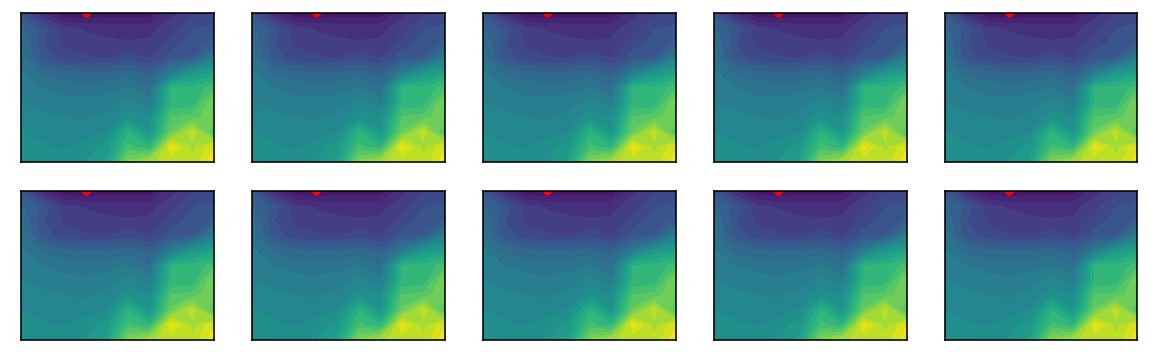

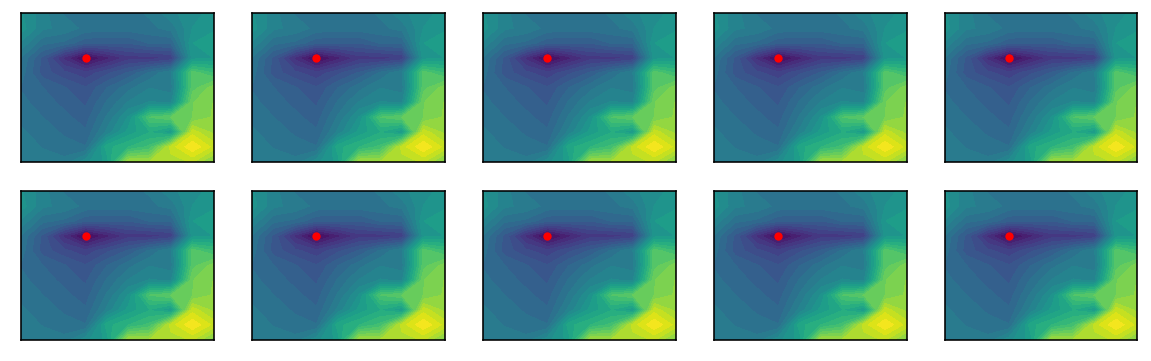

In [ ]:
res1 = import_datasets(['./gg_211118_nsc11_10x11_75gen_1/result.pickle'])
res2 = import_datasets(['./gg_211118_nsc23_10x11_75gen_1/result.pickle'])

res1.find_best_params()
res2.find_best_params()
chisq_best_param_correction(res1,overwrite=True)
chisq_best_param_correction(res2,overwrite=True)

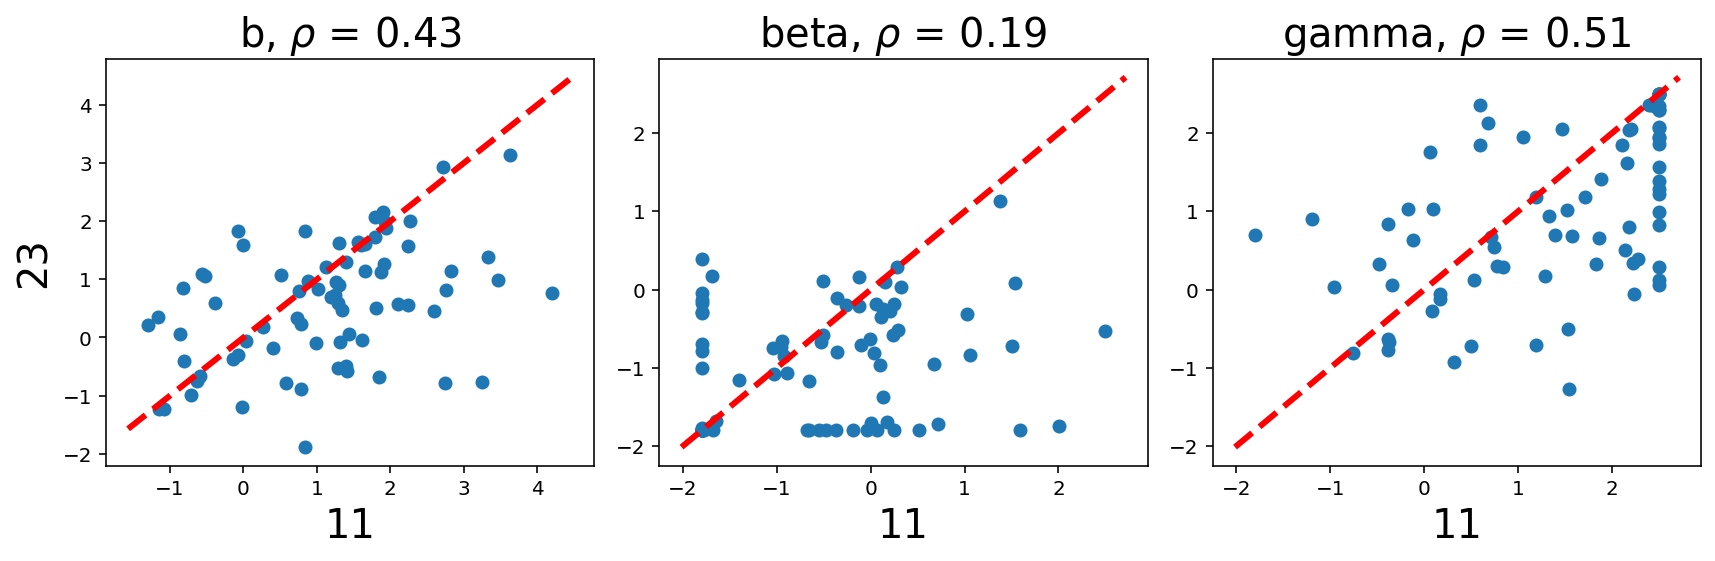

In [ ]:

fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
nbin=30
for j in range(3):
    ax1[j].scatter(res1.best_phys_params[:,j],
               res2.best_phys_params[:,j])

    fs=20
    rho=np.corrcoef(res1.best_phys_params[:,j],res2.best_phys_params[:,j])[0][1]
    ax1[j].set_title(r'{}, $\rho$ = {:.2f}'.format(param_nm[j],rho),fontsize=fs)
    xl = ax1[j].get_xlim()
    ax1[j].plot(xl,xl,'--',color='r',linewidth=3)
    ax1[j].set_xlabel(dataset_names[0],fontsize=fs)
    
    if j==0:
        ax1[j].set_ylabel(dataset_names[1],fontsize=fs)

fig1.tight_layout()


In [ ]:
param_nm = ['b','beta','gamma']
fs=10
dataset_names = ['11','23']

In [ ]:
in_ = res2.best_ind

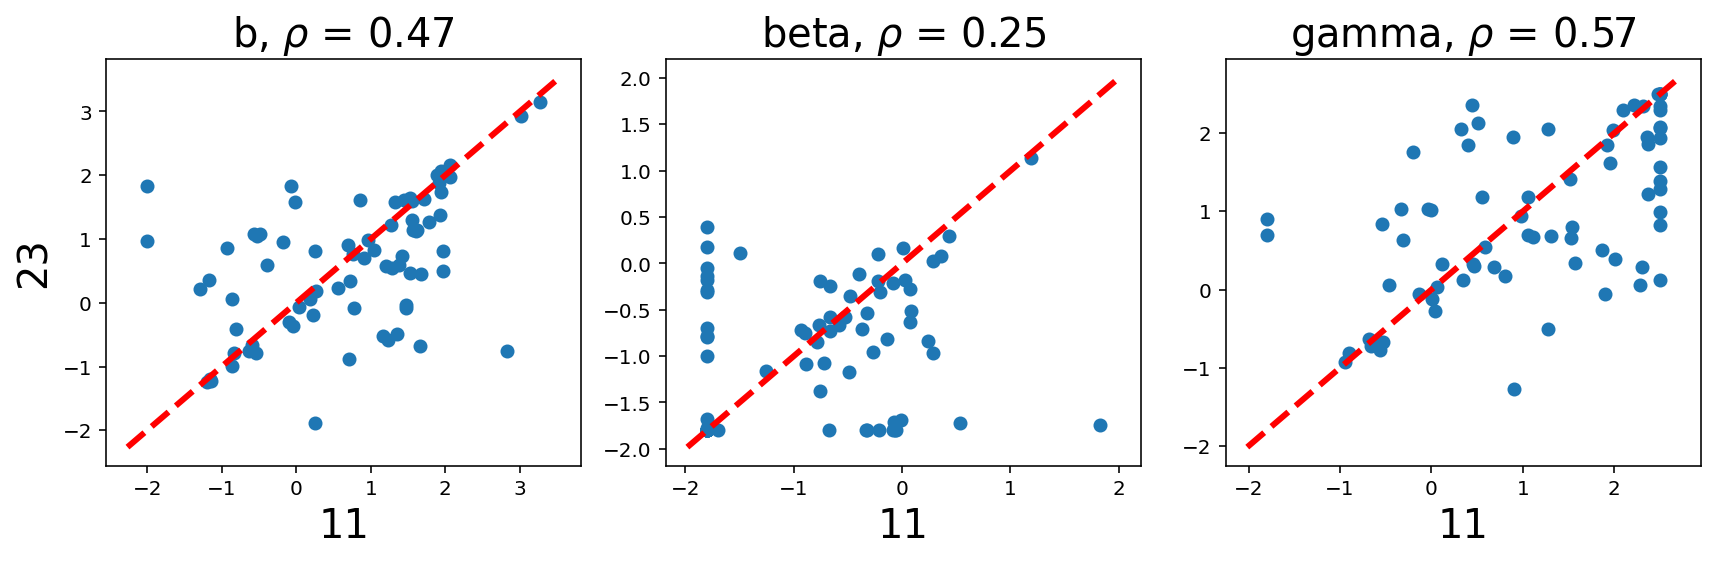

In [ ]:

fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
nbin=30
for j in range(3):
    ax1[j].scatter(res1.gene_params[in_,:,j],
               res2.gene_params[in_,:,j])

    fs=20
    rho=np.corrcoef(res1.gene_params[in_,:,j],res2.gene_params[in_,:,j])[0][1]
    ax1[j].set_title(r'{}, $\rho$ = {:.2f}'.format(param_nm[j],rho),fontsize=fs)
    xl = ax1[j].get_xlim()
    ax1[j].plot(xl,xl,'--',color='r',linewidth=3)
    ax1[j].set_xlabel(dataset_names[0],fontsize=fs)
    
    if j==0:
        ax1[j].set_ylabel(dataset_names[1],fontsize=fs)

fig1.tight_layout()


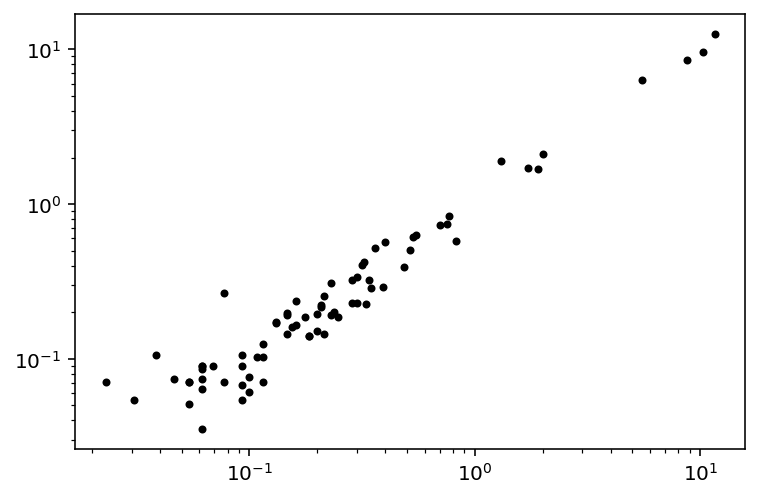

In [ ]:
plt.loglog(res1.raw_S.mean(1),res2.raw_S.mean(1),'k.')

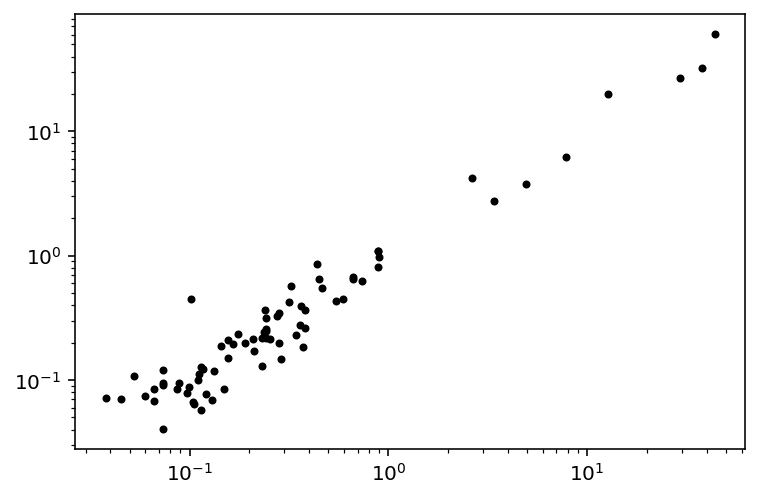

In [ ]:
plt.loglog(res1.raw_S.var(1),res2.raw_S.var(1),'k.')

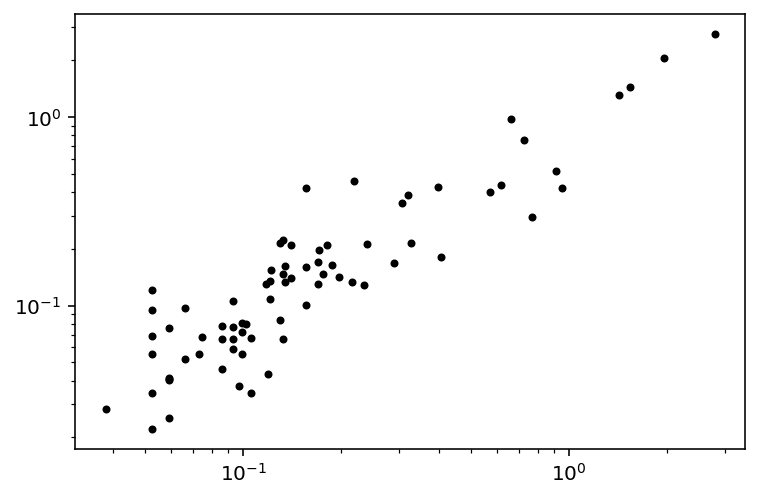

In [ ]:
plt.loglog(res1.raw_U.var(1),res2.raw_U.var(1),'k.')

In [ ]:
!zip jasefit.zip *

  adding: driver.py (deflated 70%)
  adding: example_fit.ipynb (deflated 26%)
  adding: example_input_0.txt (deflated 51%)
  adding: example_input_1.txt (deflated 51%)
  adding: example_input_dryrun.txt (deflated 51%)
  adding: gg_200524_mouse_genome_polyA_cum_1 (deflated 89%)
  adding: gg_200525_genome_polyA_cum_3 (deflated 88%)
  adding: gg210623_seq_figgen.ipynb (deflated 27%)
  adding: gg_211116_mouse_genome_len_cum_geneid_1 (deflated 95%)
  adding: gg_211118_filtered_genes.csv (deflated 27%)
  adding: gg_211118_nsc11_10x11_75gen_1/ (stored 0%)
  adding: gg_211118_nsc11_23_20x21_50gen_1/ (stored 0%)
  adding: gg_211118_nsc23_10x11_75gen_1/ (stored 0%)
  adding: gg_211118_nsc45_20x21_50gen_1/ (stored 0%)
  adding: gg_211118_selected_genes.csv (deflated 28%)
  adding: gg__filtered_genes.csv (deflated 24%)
  adding: gg__nsc11_23_10x11_50gen_1/ (stored 0%)
  adding: gg__nsc45_10x11_50gen_1/ (stored 0%)
  adding: gg__selected_genes.csv (deflated 25%)
  adding: loom_fbc/ (stored 0%)
  ad